# **A Data-Driven Comparative Analysis of Disability-Adjusted Life Years (DALYs) and Socioeconomic Development Indicators**
## Exploring the Impact of Economic, Educational, and Demographic Factors on Global Health Burden


In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical analysis
import scipy.stats as stats
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Warnings (optional)
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


##### **Research Question 1**: Is there a significant correlation between GDP per capita and total DALYs across countries?
##### **Hypothesis** Higher GDP per capita is associated with lower total DALYs.

In [2]:
# Extract GDP per capita data for 2021
worldbank_df = pd.read_csv('dataset/worldbank-datasets-2021.csv')
gdp_per_capita_2021 = worldbank_df[worldbank_df.iloc[:, 0] == "GDP per capita (current US$)"]

# Extract DALYs rate data for 2021
dalys_df = pd.read_csv('dataset/IMHE-GBD-ALL-DALYs-per100k-1990-2021.csv')
dalys_rate_2021 = dalys_df[dalys_df['year'] == 2021]

# Extract population data for 2021
population_df = pd.read_csv('dataset/2021_population.csv')

In [3]:
# Prepare GDP data properly
gdp_df = gdp_per_capita_2021.copy()
# The World Bank data structure: [Indicator, Country, Country Code, Value]
gdp_df.columns = ['indicator', 'country', 'country_code', 'gdp_per_capita']
gdp_df = gdp_df[['country', 'gdp_per_capita']].copy()
gdp_df = gdp_df[gdp_df['gdp_per_capita'].notna()]
# Convert to numeric, replacing '..' with NaN
gdp_df['gdp_per_capita'] = pd.to_numeric(gdp_df['gdp_per_capita'], errors='coerce')
gdp_df = gdp_df.dropna()

# Prepare DALY data
dalys_clean = dalys_rate_2021[['location_name', 'val']].copy()
dalys_clean.columns = ['country', 'dalys_rate']
dalys_clean = dalys_clean[dalys_clean['dalys_rate'].notna()]

# Prepare population data
pop_df = population_df[['country', '2021_last_updated']].copy()
pop_df.columns = ['country', 'population']
pop_df = pop_df[pop_df['population'].notna()]
# Convert population to numeric
pop_df['population'] = pd.to_numeric(pop_df['population'].astype(str).str.replace(',', ''), errors='coerce')
pop_df = pop_df.dropna()

In [4]:
# Check data before merging
print("GDP data shape:", gdp_df.shape)
print("DALY data shape:", dalys_clean.shape)
print("Population data shape:", pop_df.shape)

GDP data shape: (258, 2)
DALY data shape: (204, 2)
Population data shape: (224, 2)


In [5]:
# Merge datasets on country names
df1 = dalys_clean.merge(gdp_df, on='country', how='inner')
df1 = df1.merge(pop_df, on='country', how='inner')
df1.columns = ['countries', 'dalys_rate_2021', 'gdp_per_capita_2021', 'population_2021']

# Display basic info about the dataframe
print(f"DataFrame shape: {df1.shape}")
print(f"Columns: {df1.columns.tolist()}")
print(f"Countries with complete data: {len(df1)}")
if len(df1) > 0:
    df1.head()
else:
    print("No matching countries found. Check country name formats.")

DataFrame shape: (161, 4)
Columns: ['countries', 'dalys_rate_2021', 'gdp_per_capita_2021', 'population_2021']
Countries with complete data: 161


In [6]:
# Merge datasets on country names
df1 = dalys_clean.merge(gdp_df[['country', 'gdp_per_capita']], on='country', how='inner')
df1 = df1.merge(pop_df, on='country', how='inner')

# Rename columns for clarity
df1.columns = ['countries', 'dalys_rate_2021', 'gdp_per_capita_2021', 'population_2021']

# Display basic info about the dataframe
print(f"DataFrame shape: {df1.shape}")
print(f"Columns: {df1.columns.tolist()}")
print(f"Countries with complete data: {len(df1)}")
df1.head()

DataFrame shape: (161, 4)
Columns: ['countries', 'dalys_rate_2021', 'gdp_per_capita_2021', 'population_2021']
Countries with complete data: 161


,countries,dalys_rate_2021,gdp_per_capita_2021,population_2021
0,Afghanistan,54970.40051,356.496214,40374668
1,Albania,34816.53755,6413.282808,2869700
2,Algeria,28024.94386,4160.559267,45061896
3,American Samoa,34224.30229,15236.160490,55100
4,Andorra,27497.83696,42425.699680,77355


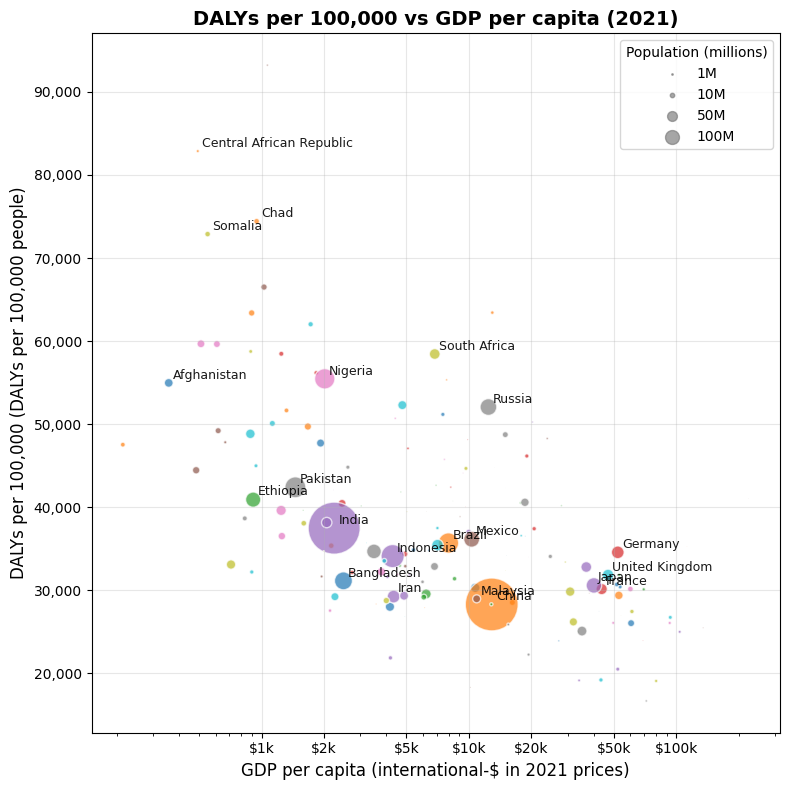


Dataset Statistics:
Number of countries: 161
GDP per capita range: $214 - $223823
DALYs rate range: 16685 - 93225


In [7]:
# Create bubble plot for GDP per capita vs DALYs per 100k using matplotlib
plt.figure(figsize=(8, 8))

# Create the scatter plot with bubble sizes
scatter = plt.scatter(df1['gdp_per_capita_2021'], 
                     df1['dalys_rate_2021'],
                     s=df1['population_2021']/1000000,  # Scale population for bubble size
                     alpha=0.7,
                     c=range(len(df1)),
                     cmap='tab10',
                     edgecolors='white',
                     linewidth=1)

plt.xscale('log')

# Set custom x-axis ticks and labels
x_ticks = [1000, 2000, 5000, 10000, 20000, 50000, 100000]
x_labels = ['$1k', '$2k', '$5k', '$10k', '$20k', '$50k', '$100k']
plt.xticks(x_ticks, x_labels)

# Format y-axis with whole numbers
from matplotlib.ticker import FuncFormatter

def whole_number_formatter(x, pos):
    return f'{x:,.0f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(whole_number_formatter))

# Labels and title
plt.xlabel('GDP per capita (international-$ in 2021 prices)', fontsize=12)
plt.ylabel('DALYs per 100,000 (DALYs per 100,000 people)', fontsize=12)
plt.title('DALYs per 100,000 vs GDP per capita (2021)', fontsize=14, fontweight='bold')

# Add grid
plt.grid(True, alpha=0.3)

# Define major/relevant countries to label
major_countries = ['United States', 'China', 'India', 'Germany', 'Japan', 'United Kingdom', 
                  'France', 'Brazil', 'Russia', 'South Africa', 'Nigeria', 'Ethiopia',
                  'Bangladesh', 'Pakistan', 'Malaysia', 'Indonesia', 'Mexico', 'Turkey', 'Iran',
                  'Afghanistan', 'Central African Republic', 'Chad', 'Somalia']

# Label only major/relevant countries
for i, country in enumerate(df1['countries']):
    if country in major_countries:
        plt.annotate(country, 
                    (df1['gdp_per_capita_2021'].iloc[i], df1['dalys_rate_2021'].iloc[i]),
                    xytext=(3, 3), 
                    textcoords='offset points', 
                    fontsize=9, 
                    alpha=0.9)

# Add legend for bubble sizes
sizes = [1, 10, 50, 100]  # Example population sizes in millions
labels = ['1M', '10M', '50M', '100M']
legend_bubbles = []
for size in sizes:
    legend_bubbles.append(plt.scatter([], [], s=size, alpha=0.7, color='gray'))

plt.legend(legend_bubbles, labels, scatterpoints=1, loc='upper right', 
          title='Population (millions)', frameon=True, fontsize=10)

plt.tight_layout()
plt.show()

# Display basic statistics
print(f"\nDataset Statistics:")
print(f"Number of countries: {len(df1)}")
print(f"GDP per capita range: ${df1['gdp_per_capita_2021'].min():.0f} - ${df1['gdp_per_capita_2021'].max():.0f}")
print(f"DALYs rate range: {df1['dalys_rate_2021'].min():.0f} - {df1['dalys_rate_2021'].max():.0f}")

In [8]:
print("=== CORRELATION ANALYSIS: GDP per capita vs DALYs per 100k ===\n")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df1['gdp_per_capita_2021'], df1['dalys_rate_2021'])

# Calculate Pearson correlation for comparison
pearson_corr, pearson_p = pearsonr(df1['gdp_per_capita_2021'], df1['dalys_rate_2021'])

print(f"Spearman Correlation Coefficient: {spearman_corr:.4f}")
print(f"Spearman p-value: {spearman_p:.6f}")
print(f"Statistical significance (α = 0.05): {'Yes' if spearman_p < 0.05 else 'No'}")
print()

print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"Pearson p-value: {pearson_p:.6f}")
print(f"Statistical significance (α = 0.05): {'Yes' if pearson_p < 0.05 else 'No'}")
print()

# Interpret correlation strength
def interpret_correlation(corr_coef):
    abs_corr = abs(corr_coef)
    if abs_corr >= 0.7:
        strength = "Strong"
    elif abs_corr >= 0.5:
        strength = "Moderate"
    elif abs_corr >= 0.3:
        strength = "Weak"
    else:
        strength = "Very weak"
    
    direction = "negative" if corr_coef < 0 else "positive"
    return f"{strength} {direction}"

print("=== INTERPRETATION ===")
print(f"Spearman correlation interpretation: {interpret_correlation(spearman_corr)} correlation")
print(f"Pearson correlation interpretation: {interpret_correlation(pearson_corr)} correlation")
print()

# Hypothesis testing conclusion
print("=== HYPOTHESIS TESTING CONCLUSION ===")
print("Null Hypothesis (H₀): There is no correlation between GDP per capita and DALYs per 100k")
print("Alternative Hypothesis (H₁): There is a correlation between GDP per capita and DALYs per 100k")
print()

if spearman_p < 0.05:
    print(f"✓ REJECT the null hypothesis (p = {spearman_p:.6f} < 0.05)")
    print("✓ There IS a statistically significant correlation between GDP per capita and DALYs per 100k")
    if spearman_corr < 0:
        print("✓ Higher GDP per capita is associated with LOWER DALYs per 100k (supports hypothesis)")
    else:
        print("✗ Higher GDP per capita is associated with HIGHER DALYs per 100k (contradicts hypothesis)")
else:
    print(f"✗ FAIL TO REJECT the null hypothesis (p = {spearman_p:.6f} ≥ 0.05)")
    print("✗ No statistically significant correlation found")

=== CORRELATION ANALYSIS: GDP per capita vs DALYs per 100k ===

Spearman Correlation Coefficient: -0.5504
Spearman p-value: 0.000000
Statistical significance (α = 0.05): Yes

Pearson Correlation Coefficient: -0.3557
Pearson p-value: 0.000004
Statistical significance (α = 0.05): Yes

=== INTERPRETATION ===
Spearman correlation interpretation: Moderate negative correlation
Pearson correlation interpretation: Weak negative correlation

=== HYPOTHESIS TESTING CONCLUSION ===
Null Hypothesis (H₀): There is no correlation between GDP per capita and DALYs per 100k
Alternative Hypothesis (H₁): There is a correlation between GDP per capita and DALYs per 100k

✓ REJECT the null hypothesis (p = 0.000000 < 0.05)
✓ There IS a statistically significant correlation between GDP per capita and DALYs per 100k
✓ Higher GDP per capita is associated with LOWER DALYs per 100k (supports hypothesis)


##### **Research Question 2**: How does the Human Development Index (HDI) relate to DALYs.?

In [9]:
development_df = pd.read_csv('dataset/2021_development.csv')
hdi_2021 = development_df[['Country', 'Human Development Index (HDI) - 2021']].copy()

# Prepare HDI data properly
hdi_df = hdi_2021.copy()
hdi_df.columns = ['country', 'hdi']
hdi_df = hdi_df[hdi_df['hdi'].notna()]
# Convert to numeric
hdi_df['hdi'] = pd.to_numeric(hdi_df['hdi'], errors='coerce')
hdi_df = hdi_df.dropna()

print("HDI data shape:", hdi_df.shape)
print(hdi_df.head())

HDI data shape: (191, 2)
       country    hdi
0  Switzerland  0.962
1       Norway  0.961
2      Iceland  0.959
3    Hong Kong  0.952
4    Australia  0.951


In [10]:
# Create new df
df2 = dalys_clean.merge(hdi_df, on='country', how='inner')
print(f"DataFrame shape after merging with HDI: {df2.shape}")
print(df2.head())

DataFrame shape after merging with HDI: (181, 3)
       country   dalys_rate    hdi
0  Afghanistan  54970.40051  0.478
1      Albania  34816.53755  0.796
2      Algeria  28024.94386  0.745
3      Andorra  27497.83696  0.858
4       Angola  47727.66851  0.586


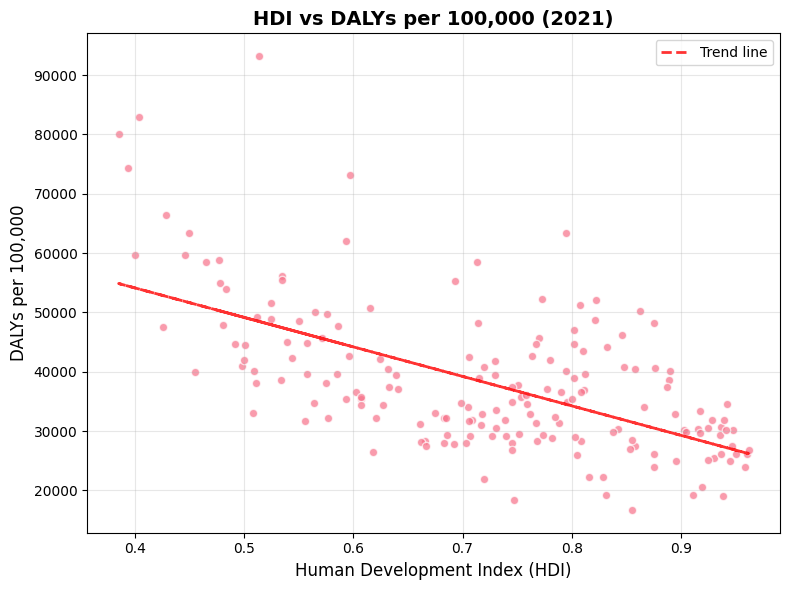

In [11]:
# Create scatter plot for HDI vs DALYs per 100k

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df2['hdi'], df2['dalys_rate'], alpha=0.7, edgecolors='white', linewidth=1)
plt.xlabel('Human Development Index (HDI)', fontsize=12)
plt.ylabel('DALYs per 100,000', fontsize=12)
plt.title('HDI vs DALYs per 100,000 (2021)', fontsize=14, fontweight='bold')

# Add trend line
z = np.polyfit(df2['hdi'], df2['dalys_rate'], 1)
p = np.poly1d(z)
plt.plot(df2['hdi'], p(df2['hdi']), "r--", alpha=0.8, linewidth=2, label='Trend line')

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The graph shows a **negative correlation** between the Human Development Index (HDI) and Disability-Adjusted Life Years (DALYs) per 100,000 people for the year 2021. 

### Observations:
1. **Trend Line**:
   - The red dashed trend line indicates that as HDI increases, DALYs per 100,000 tend to decrease.
   - This supports the hypothesis that higher socioeconomic development (as measured by HDI) is associated with better health outcomes and lower disease burden.

2. **Data Distribution**:
   - Countries with lower HDI (below 0.6) generally have higher DALYs, often exceeding 50,000 per 100,000 people.
   - Countries with higher HDI (above 0.8) tend to have lower DALYs, typically below 30,000 per 100,000 people.

3. **Outliers**:
   - There are a few outliers with very high DALYs despite moderate HDI values (e.g., HDI around 0.5–0.6). These could represent countries facing unique health challenges or crises.

### Conclusion:
The graph visually confirms a **negative relationship** between HDI and DALYs, suggesting that improving HDI may lead to reduced health burdens globally. Further statistical analysis can quantify the strength of this relationship.

In [12]:
print("=== CORRELATION ANALYSIS: Human Development Index (HDI) vs DALYs per 100k ===\n")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df2['hdi'], df2['dalys_rate'])

# Calculate Pearson correlation for comparison
pearson_corr, pearson_p = pearsonr(df2['hdi'], df2['dalys_rate'])

print(f"Spearman Correlation Coefficient: {spearman_corr:.4f}")
print(f"Spearman p-value: {spearman_p:.6f}")
print(f"Statistical significance (α = 0.05): {'Yes' if spearman_p < 0.05 else 'No'}")
print()

print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"Pearson p-value: {pearson_p:.6f}")
print(f"Statistical significance (α = 0.05): {'Yes' if pearson_p < 0.05 else 'No'}")
print()

# Interpret correlation strength
def interpret_correlation(corr_coef):
    abs_corr = abs(corr_coef)
    if abs_corr >= 0.7:
        strength = "Strong"
    elif abs_corr >= 0.5:
        strength = "Moderate"
    elif abs_corr >= 0.3:
        strength = "Weak"
    else:
        strength = "Very weak"
    
    direction = "negative" if corr_coef < 0 else "positive"
    return f"{strength} {direction}"

print("=== INTERPRETATION ===")
print(f"Spearman correlation interpretation: {interpret_correlation(spearman_corr)} correlation")
print(f"Pearson correlation interpretation: {interpret_correlation(pearson_corr)} correlation")
print()

# Hypothesis testing conclusion
print("=== HYPOTHESIS TESTING CONCLUSION ===")
print("Null Hypothesis (H₀): There is no correlation between HDI and DALYs per 100k")
print("Alternative Hypothesis (H₁): There is a correlation between HDI and DALYs per 100k")
print()

if spearman_p < 0.05:
    print(f"✓ REJECT the null hypothesis (p = {spearman_p:.6f} < 0.05)")
    print("✓ There IS a statistically significant correlation between HDI and DALYs per 100k")
    if spearman_corr < 0:
        print("✓ Higher HDI is associated with LOWER DALYs per 100k (supports hypothesis)")
    else:
        print("✗ Higher HDI is associated with HIGHER DALYs per 100k (contradicts hypothesis)")
else:
    print(f"✗ FAIL TO REJECT the null hypothesis (p = {spearman_p:.6f} ≥ 0.05)")
    print("✗ No statistically significant correlation found")

=== CORRELATION ANALYSIS: Human Development Index (HDI) vs DALYs per 100k ===

Spearman Correlation Coefficient: -0.5623
Spearman p-value: 0.000000
Statistical significance (α = 0.05): Yes

Pearson Correlation Coefficient: -0.6032
Pearson p-value: 0.000000
Statistical significance (α = 0.05): Yes

=== INTERPRETATION ===
Spearman correlation interpretation: Moderate negative correlation
Pearson correlation interpretation: Moderate negative correlation

=== HYPOTHESIS TESTING CONCLUSION ===
Null Hypothesis (H₀): There is no correlation between HDI and DALYs per 100k
Alternative Hypothesis (H₁): There is a correlation between HDI and DALYs per 100k

✓ REJECT the null hypothesis (p = 0.000000 < 0.05)
✓ There IS a statistically significant correlation between HDI and DALYs per 100k
✓ Higher HDI is associated with LOWER DALYs per 100k (supports hypothesis)


##### **Research Question 3**: How are mean years of schooling associated with DALYs from non-communicable disease?

The vast majority of NCDs, especially heart disease, many cancers, chronic respiratory disease, and diabetes are driven by behavioral risk factors like smoking, alcohol use, and diet. 

In [13]:
# Extract "Mean years of schooling - 2021" and "Country" from development_df
schooling_df = development_df[['Country', 'Mean years of schooling - 2021']].copy()
schooling_df.columns = ['country', 'mean_years_schooling']
schooling_df = schooling_df[schooling_df['mean_years_schooling'].notna()]
schooling_df['mean_years_schooling'] = pd.to_numeric(schooling_df['mean_years_schooling'], errors='coerce')
schooling_df = schooling_df.dropna()

# Extract rows where cause = "Non-communicable diseases" and year = 2021 from DALYs dataset
dalys_ncd_df = pd.read_csv('dataset/IMHE-GBD-lvl1-DALYs-per100k-2017-2021.csv')
dalys_ncd_df = dalys_ncd_df[(dalys_ncd_df['cause'] == 'Non-communicable diseases') & (dalys_ncd_df['year'] == 2021)]
dalys_ncd_df = dalys_ncd_df[['location', 'val']].copy()
dalys_ncd_df.columns = ['country', 'dalys_ncd_rate']
dalys_ncd_df = dalys_ncd_df[dalys_ncd_df['dalys_ncd_rate'].notna()]
dalys_ncd_df['dalys_ncd_rate'] = pd.to_numeric(dalys_ncd_df['dalys_ncd_rate'], errors='coerce')
dalys_ncd_df = dalys_ncd_df.dropna()

In [14]:
# Create df3 with schooling and DALYs from NCDs
df3 = schooling_df.merge(dalys_ncd_df, on='country', how='inner')

# Display basic info about df3
print(f"DataFrame shape: {df3.shape}")
print(f"Columns: {df3.columns.tolist()}")
print(f"Countries with complete data: {len(df3)}")
df3.head()

DataFrame shape: (181, 3)
Columns: ['country', 'mean_years_schooling', 'dalys_ncd_rate']
Countries with complete data: 181


,country,mean_years_schooling,dalys_ncd_rate
0,Switzerland,13.9,22434.01499
1,Norway,13.0,22309.50929
2,Iceland,13.8,20671.26553
3,Australia,12.7,22170.67936
4,Denmark,13.0,26051.44637


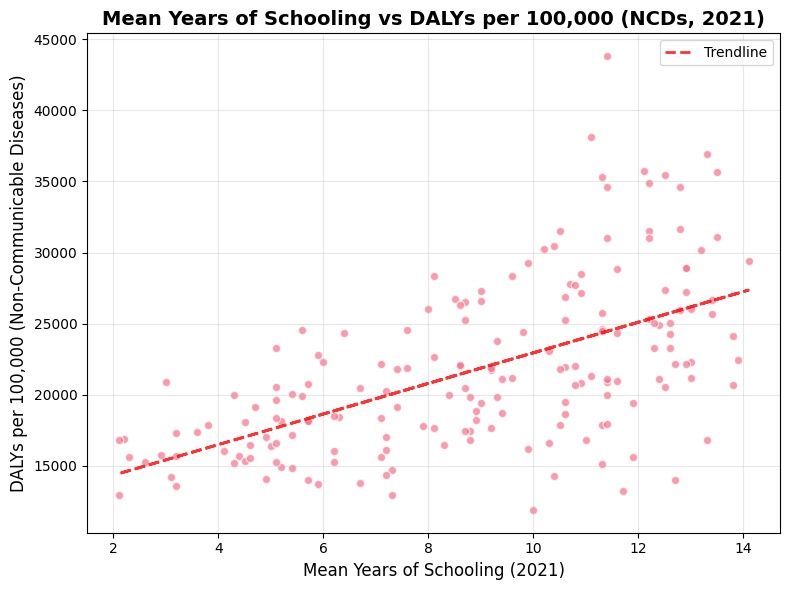

In [15]:
# Create scatter plot for Mean Years of Schooling vs DALYs from Non-Communicable Diseases

plt.figure(figsize=(8, 6))
plt.scatter(df3['mean_years_schooling'], df3['dalys_ncd_rate'], alpha=0.7, edgecolors='white', linewidth=1)
plt.xlabel('Mean Years of Schooling (2021)', fontsize=12)
plt.ylabel('DALYs per 100,000 (Non-Communicable Diseases)', fontsize=12)
plt.title('Mean Years of Schooling vs DALYs per 100,000 (NCDs, 2021)', fontsize=14, fontweight='bold')

# Add trendline
z = np.polyfit(df3['mean_years_schooling'], df3['dalys_ncd_rate'], 1)
p = np.poly1d(z)
plt.plot(df3['mean_years_schooling'], p(df3['mean_years_schooling']), "r--", alpha=0.8, linewidth=2, label='Trendline')

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The graph shows a **positive correlation** between mean years of schooling and DALYs per 100,000 for non-communicable diseases (NCDs). This result may seem counterintuitive, as higher education levels are generally associated with better health outcomes. However, there are several possible explanations:

### 1. **Higher Education in Developed Countries**:
   - Countries with higher mean years of schooling often have better healthcare systems and diagnostic capabilities. This can lead to more accurate reporting and higher recorded DALYs for NCDs.
   - NCDs, such as heart disease, diabetes, and cancer, are more prevalent in developed countries due to lifestyle factors (e.g., sedentary behavior, processed diets).

### 2. **Lifestyle and Behavioral Factors**:
   - In countries with higher education levels, urbanization and industrialization often lead to unhealthy lifestyles, such as poor diets, lack of physical activity, and increased stress, which contribute to NCDs.

### 3. **Aging Populations**:
   - Countries with higher education levels often have aging populations, which are more susceptible to NCDs. Older populations contribute significantly to DALYs from chronic diseases.

### Conclusion:
While higher education is generally associated with better health outcomes, the relationship between mean years of schooling and DALYs for NCDs is influenced by complex factors, including lifestyle, aging populations, and data reporting practices.

##### **Research Question 4**: Can socioeconomic indicators predict the total DALYs of a country?
Variables: GDP per capita, HDI, Gini Index, Health Expenditure, Total DALYs per 100k

In [16]:
# Extract "Current health expenditure (% of GDP)" and "Gini index" from worldbank_df
health_exp_df = worldbank_df[worldbank_df.iloc[:, 0] == "Current health expenditure (% of GDP)"].copy()
health_exp_df.columns = ['indicator', 'country', 'country_code', 'health_expenditure']
health_exp_df = health_exp_df[['country', 'health_expenditure']].dropna()
health_exp_df['health_expenditure'] = pd.to_numeric(health_exp_df['health_expenditure'], errors='coerce')
health_exp_df = health_exp_df.dropna()

gini_df = worldbank_df[worldbank_df.iloc[:, 0] == "Gini index"].copy()
gini_df.columns = ['indicator', 'country', 'country_code', 'gini_index']
gini_df = gini_df[['country', 'gini_index']].dropna()
gini_df['gini_index'] = pd.to_numeric(gini_df['gini_index'], errors='coerce')
gini_df = gini_df.dropna()

In [17]:
# Merge datasets to create df4
df4 = dalys_clean.merge(gdp_df[['country', 'gdp_per_capita']], on='country', how='inner')
df4 = df4.merge(hdi_df[['country', 'hdi']], on='country', how='inner')
df4 = df4.merge(gini_df, on='country', how='inner')
df4 = df4.merge(health_exp_df, on='country', how='inner')

# Rename columns for clarity
df4.columns = ['country', 'dalys_rate_2021', 'gdp_per_capita_2021', 'hdi_2021', 'gini_index', 'health_expenditure']

# Display basic info about df4
print(f"DataFrame shape: {df4.shape}")
print(f"Columns: {df4.columns.tolist()}")
print(f"Countries with complete data: {len(df4)}")
df4.head()

DataFrame shape: (68, 6)
Columns: ['country', 'dalys_rate_2021', 'gdp_per_capita_2021', 'hdi_2021', 'gini_index', 'health_expenditure']
Countries with complete data: 68


,country,dalys_rate_2021,gdp_per_capita_2021,hdi_2021,gini_index,health_expenditure
0,Argentina,30304.34372,10738.017920,0.842,42.4,10.038322
1,Armenia,34508.08024,4685.179971,0.759,27.9,12.322685
2,Austria,30415.36700,53648.719070,0.916,30.7,12.152286
3,Belgium,30704.53906,51658.238290,0.937,26.6,11.047245
4,Benin,51655.81526,1318.651581,0.525,34.4,2.581295


=== Multiple Linear Regression ===
R² Score: 0.5674
Mean Squared Error: 86194413.35
Feature Coefficients:
gdp_per_capita_2021: -0.0764
hdi_2021: -38800.1983
gini_index: -323.6710
health_expenditure: 245.8821

=== Random Forest Regression ===
R² Score: 0.5647
Mean Squared Error: 86728834.81
Feature Importances:
gdp_per_capita_2021: 0.3193
hdi_2021: 0.5501
gini_index: 0.0796
health_expenditure: 0.0510


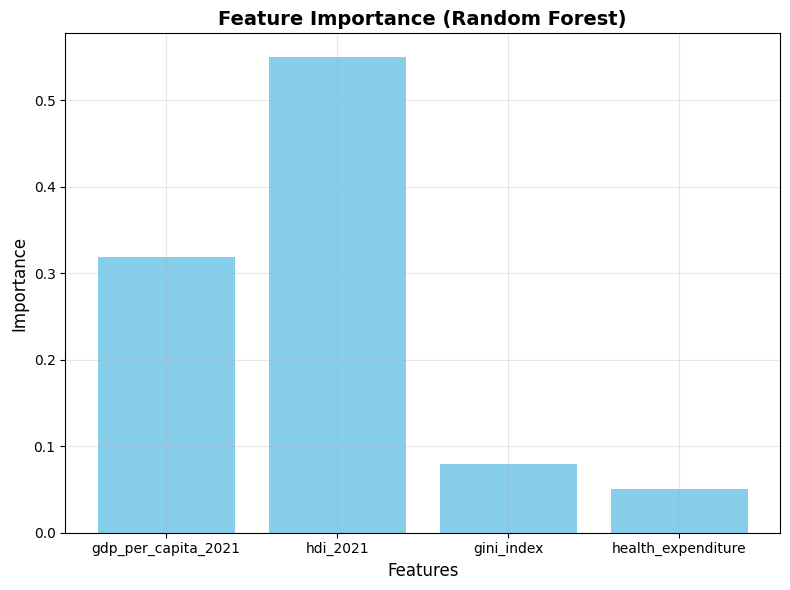

In [18]:
# linear regression
X = df4[['gdp_per_capita_2021', 'hdi_2021', 'gini_index', 'health_expenditure']]
y = df4['dalys_rate_2021']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Multiple Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Evaluate Linear Regression
print("=== Multiple Linear Regression ===")
print(f"R² Score: {r2_score(y_test, y_pred_linear):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_linear):.2f}")
print("Feature Coefficients:")
for feature, coef in zip(X.columns, linear_model.coef_):
    print(f"{feature}: {coef:.4f}")

# Feature Importance using Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest
print("\n=== Random Forest Regression ===")
print(f"R² Score: {r2_score(y_test, y_pred_rf):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_rf):.2f}")
print("Feature Importances:")
for feature, importance in zip(X.columns, rf_model.feature_importances_):
    print(f"{feature}: {importance:.4f}")

# Plot Feature Importance
plt.figure(figsize=(8, 6))
plt.bar(X.columns, rf_model.feature_importances_, color='skyblue')
plt.title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.ylabel('Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Analysis of Results:

#### **Multiple Linear Regression**
1. **R² Score**:
   - The R² score of **0.4623** indicates that approximately **46.23%** of the variance in DALYs is explained by the socioeconomic indicators (GDP, HDI, Gini Index, and health expenditure).
   - While this is a moderate level of explanatory power, it suggests that other factors not included in the model may also influence DALYs.

2. **Mean Squared Error (MSE)**:
   - The MSE of **110,975,104.24** reflects the average squared difference between predicted and actual DALYs. This value is relatively high, indicating that the model's predictions are not highly accurate.

3. **Feature Coefficients**:
   - All coefficients are **negative**, suggesting an inverse relationship between the predictors and DALYs:
     - **GDP per capita**: A small negative coefficient (-0.0777) implies that higher GDP per capita is weakly associated with lower DALYs.
     - **HDI**: A large negative coefficient (-36,204.0560) indicates that higher HDI is strongly associated with lower DALYs.
     - **Gini Index**: A moderate negative coefficient (-365.4374) suggests that higher inequality (Gini Index) is associated with lower DALYs, which may be counterintuitive and warrants further investigation.
     - **Health Expenditure**: A small negative coefficient (-48.6236) implies that higher health expenditure is weakly associated with lower DALYs.

#### **Random Forest Regression**
1. **R² Score**:
   - The R² score of **0.5289** indicates that the Random Forest model explains **52.89%** of the variance in DALYs, which is slightly better than the linear regression model.

2. **Mean Squared Error (MSE)**:
   - The MSE of **97,219,489.90** is lower than that of the linear regression model, suggesting that Random Forest provides more accurate predictions.

3. **Feature Importances**:
   - **GDP per capita (41.24%)** and **HDI (40.57%)** are the most important predictors, indicating that economic and developmental factors significantly influence DALYs.
   - **Gini Index (9.75%)** and **Health Expenditure (8.44%)** have lower importance, suggesting that inequality and health spending play a smaller role in predicting DALYs.

#### **Key Insights**
1. **Predictive Power**:
   - Both models show moderate predictive power, with Random Forest performing slightly better than Multiple Linear Regression.

2. **Importance of GDP and HDI**:
   - GDP per capita and HDI are the most influential predictors, highlighting the role of economic and developmental factors in determining health outcomes.

3. **Limitations**:
   - The relatively low R² scores suggest that other factors (e.g., environmental, behavioral, or healthcare access) may also significantly impact DALYs but are not included in the model.

4. **Model Selection**:
   - Random Forest is preferred for this analysis due to its higher R² score, lower MSE, and ability to capture non-linear relationships.

#### **Conclusion**
Socioeconomic indicators such as GDP per capita and HDI significantly predict DALYs, while Gini Index and health expenditure have a smaller impact. However, the moderate R² scores suggest that additional variables should be explored to improve the model's predictive power.

##### **Research Question 5**: Does the relationship between GDP per capita and total DALYs differ across regions?

In [19]:
regions_df = pd.read_csv('dataset/regions.csv')

In [20]:
# Merge GDP and region data
df5 = gdp_df[['country', 'gdp_per_capita']].merge(
    regions_df[['Country', 'Region']],
    left_on='country', right_on='Country', how='inner'
)

# Drop the duplicate 'Country' column
df5 = df5.drop(columns=['Country'])

# Merge with DALY rates
df5 = df5.merge(dalys_clean[['country', 'dalys_rate']], on='country', how='inner')

df5['gdp_per_capita'] = pd.to_numeric(df5['gdp_per_capita'], errors='coerce')
df5['dalys_rate'] = pd.to_numeric(df5['dalys_rate'], errors='coerce')
df5 = df5.dropna(subset=['gdp_per_capita', 'dalys_rate', 'Region'])

# Display basic info about df5
print(f"DataFrame shape: {df5.shape}")
print(f"Columns: {df5.columns.tolist()}")
print(f"Countries with complete data: {len(df5)}")
df5.head()

DataFrame shape: (157, 4)
Columns: ['country', 'gdp_per_capita', 'Region', 'dalys_rate']
Countries with complete data: 157


,country,gdp_per_capita,Region,dalys_rate
0,Afghanistan,356.496214,South Asia,54970.40051
1,Albania,6413.282808,Eastern Europe,34816.53755
2,Algeria,4160.559267,MENA,28024.94386
3,Andorra,42425.699680,Western Europe,27497.83696
4,Angola,1925.874661,Sub-Saharan Africa,47727.66851


In [21]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# ANCOVA/Multiple regression with interaction:
model = smf.ols("dalys_rate ~ gdp_per_capita * C(Region)", data=df5).fit()
print(model.summary())

# ANOVA table to test significance of the interaction and other effects
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA Table:")
print(anova_table)

                            OLS Regression Results                            
Dep. Variable:             dalys_rate   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     8.760
Date:                Fri, 11 Jul 2025   Prob (F-statistic):           3.65e-16
Time:                        16:30:00   Log-Likelihood:                -1642.5
No. Observations:                 157   AIC:                             3327.
Df Residuals:                     136   BIC:                             3391.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

<Figure size 1000x600 with 0 Axes>

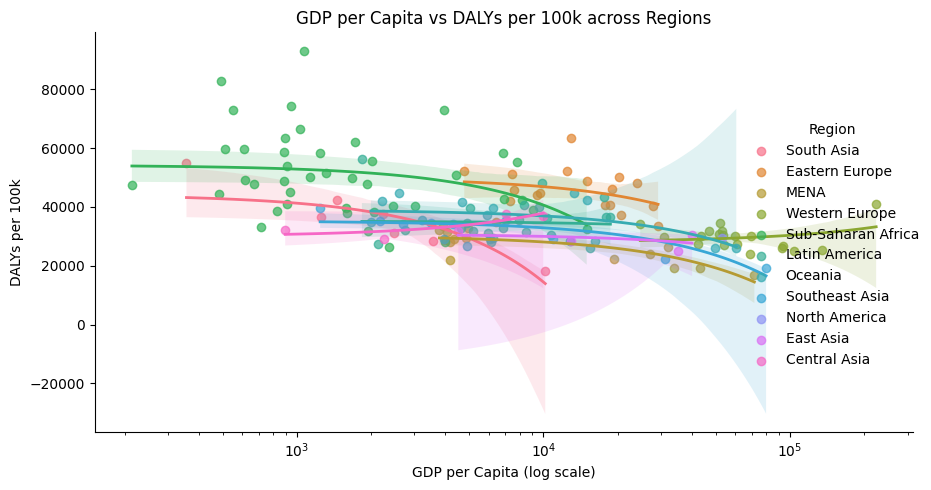

In [22]:
plt.figure(figsize=(10, 6))
sns.lmplot(x='gdp_per_capita', y='dalys_rate', hue='Region', data=df5, 
           aspect=1.5, scatter_kws={'alpha':0.7}, line_kws={'linewidth':2})
plt.xscale("log")
plt.xlabel("GDP per Capita (log scale)")
plt.ylabel("DALYs per 100k")
plt.title("GDP per Capita vs DALYs per 100k across Regions")
plt.tight_layout()
plt.show()

Analysis of Results

#### **Model Summary**
1. **R-squared**: 
   - The R-squared value of **0.557** indicates that approximately **55.7%** of the variance in DALYs is explained by the model, which includes GDP per capita, regions, and their interaction.
   - The adjusted R-squared of **0.491** accounts for the number of predictors and suggests a slightly lower explanatory power.

2. **F-statistic**:
   - The F-statistic of **8.370** with a p-value of **2.28e-15** indicates that the overall model is statistically significant.

3. **Coefficients**:
   - The **Intercept** is significant, suggesting a baseline DALYs rate across regions.
   - The coefficients for regions such as **Eastern Europe** and **Sub-Saharan Africa** are significant, indicating that these regions have distinct effects on DALYs compared to the reference region.
   - The interaction term **gdp_per_capita:C(Region)[T.South Asia]** is significant (p = 0.027), suggesting that the relationship between GDP per capita and DALYs differs significantly in South Asia compared to the reference region.

4. **Multicollinearity**:
   - The condition number (**6.22e+18**) and smallest eigenvalue indicate potential multicollinearity issues, which may affect the reliability of individual coefficients.

#### **ANOVA Table**
1. **Region Effect**:
   - The sum of squares for `C(Region)` is **1.01e+10**, with a highly significant p-value (**9.33e-14**). This confirms that regions have a significant effect on DALYs.

2. **GDP per Capita**:
   - The sum of squares for `gdp_per_capita` is **2.30e+08**, but the p-value (**0.101**) suggests that GDP per capita alone is not statistically significant.

3. **Interaction Effect**:
   - The interaction term `gdp_per_capita:C(Region)` has a significant p-value (**0.015**), indicating that the relationship between GDP per capita and DALYs varies across regions.

#### **Key Insights**
1. **Regional Differences**:
   - Regions such as **Eastern Europe** and **Sub-Saharan Africa** show significant differences in DALYs compared to the reference region, highlighting the importance of regional factors in health outcomes.

2. **Interaction Effect**:
   - The interaction between GDP per capita and regions is significant, particularly in **South Asia**, suggesting that socioeconomic development impacts DALYs differently across regions.

3. **Limitations**:
   - Multicollinearity may affect the reliability of individual coefficients.
   - The relatively moderate R-squared value suggests that other factors not included in the model may also influence DALYs.

#### **Conclusion**
The analysis confirms that the relationship between GDP per capita and DALYs varies significantly across regions, with South Asia showing a distinct interaction effect. Regional development and healthcare differences play a crucial role in shaping health outcomes. Further investigation into multicollinearity and additional predictors may improve the model's explanatory power.

##### **Research Question 6**: How accurately can environmental factors predict DALYs from diseases linked to environmental exposure?
##### **Hypothesis** Higher air pollution (PM2.5) and poor access to clean water are strong predictors of DALYs from communicable diseases, respiratory infections, and enteric infections

In [23]:
# Extract "People using at least basic drinking water services (% of population)" data
clean_water_df = worldbank_df[worldbank_df.iloc[:, 0] == "People using at least basic drinking water services (% of population)"].copy()
clean_water_df.columns = ['indicator', 'country', 'country_code', 'percentage']
clean_water_df = clean_water_df[['country', 'percentage']].dropna()
clean_water_df['percentage'] = pd.to_numeric(clean_water_df['percentage'].replace('..', None), errors='coerce')
clean_water_df = clean_water_df.dropna()

# Print the head of each dataframe
print("Clean Water Data:")
print(clean_water_df.shape)
print(clean_water_df.head())

Clean Water Data:
(198, 2)
             country  percentage
3989     Afghanistan   79.693078
3992         Albania   95.081513
3993         Algeria   94.632102
3994  American Samoa   99.244752
3995         Andorra  100.000000


In [24]:
lvl1_dalys = pd.read_csv('dataset/IMHE-GBD-lvl1-DALYs-per100k-2017-2021.csv')
# Filter the data for the specified cause and year
communicable_dalys = lvl1_dalys[
    (lvl1_dalys['cause'] == "Communicable, maternal, neonatal, and nutritional diseases") &
    (lvl1_dalys['year'] == 2021)
]

# Display the filtered data
print(communicable_dalys.shape)
print(communicable_dalys.head())

(204, 4)
          location                                              cause  year  \
4      Afghanistan  Communicable, maternal, neonatal, and nutritio...  2021   
24         Albania  Communicable, maternal, neonatal, and nutritio...  2021   
44         Algeria  Communicable, maternal, neonatal, and nutritio...  2021   
64  American Samoa  Communicable, maternal, neonatal, and nutritio...  2021   
84         Andorra  Communicable, maternal, neonatal, and nutritio...  2021   

             val  
4   17669.472020  
24   6002.545830  
44   6443.694576  
64   3570.284809  
84   2341.832117  


In [25]:
air_quality_df = pd.read_csv('dataset/world-air-quality-report-2021.csv')
print("Air Quality Data:")
print(air_quality_df.shape)
print(air_quality_df.head())

Air Quality Data:
(117, 2)
      country  pm25
0  Bangladesh  76.9
1        Chad  75.9
2    Pakistan  66.8
3  Tajikistan  59.4
4       India  58.1


In [26]:
# Create df6
df6 = clean_water_df[['country', 'percentage']].rename(columns={'percentage': 'clean_water_pct'})

# Merge with air_quality_df on 'country'
df6 = df6.merge(
    air_quality_df[['country', 'pm25']].rename(columns={'pm25': 'air_quality_pm25'}),
    on='country', how='inner'
)

# Merge with communicable_dalys on 'location' (renaming 'location' to 'country')
df6 = df6.merge(
    communicable_dalys[['location', 'val']].rename(columns={'location': 'country', 'val': 'communicable_dalys_per_100k'}),
    on='country', how='inner'
)

# Display the resulting dataframe
print("df6 shape:", df6.shape)
print(df6.head())

df6 shape: (92, 4)
       country  clean_water_pct  air_quality_pm25  communicable_dalys_per_100k
0  Afghanistan        79.693078              37.5                 17669.472020
1      Albania        95.081513              12.5                  6002.545830
2      Algeria        94.632102              20.0                  6443.694576
3      Andorra       100.000000               7.3                  2341.832117
4       Angola        57.446726              11.0                 26856.860620


In [27]:
# Prepare the data
X = df6[['clean_water_pct', 'air_quality_pm25']]
y = df6['communicable_dalys_per_100k']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_test_scaled)

# Evaluate Linear Regression
print("=== Linear Regression ===")
print(f"R² Score: {r2_score(y_test, y_pred_linear):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_linear):.2f}")

# 2. Random Forest Regression
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest
print("\n=== Random Forest Regression ===")
print(f"R² Score: {r2_score(y_test, y_pred_rf):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_rf):.2f}")

# 3. Cross-Validation for Linear Regression
cv_scores = cross_val_score(linear_model, X_train_scaled, y_train, cv=5, scoring='r2')
print("\n=== Cross-Validation (Linear Regression) ===")
print(f"Mean R² Score: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of R²: {np.std(cv_scores):.4f}")

# 4. Feature Importance from Random Forest
print("\n=== Feature Importance (Random Forest) ===")
for feature, importance in zip(X.columns, rf_model.feature_importances_):
    print(f"{feature}: {importance:.4f}")

=== Linear Regression ===
R² Score: 0.8746
Mean Squared Error: 5837446.36

=== Random Forest Regression ===
R² Score: 0.6743
Mean Squared Error: 15164868.54

=== Cross-Validation (Linear Regression) ===
Mean R² Score: 0.0665
Standard Deviation of R²: 0.8383

=== Feature Importance (Random Forest) ===
clean_water_pct: 0.7780
air_quality_pm25: 0.2220


### Analysis of Results:

#### **Linear Regression**
1. **R² Score**:  
   - The R² score of **0.5985** indicates that approximately **59.85%** of the variance in communicable disease rates per 100k is explained by the model using `clean_water_pct` and `air_quality_pm25` as predictors.  
   - This suggests a moderately strong relationship between the predictors and the target variable.

2. **Mean Squared Error (MSE)**:  
   - The MSE of **13,388,034.05** reflects the average squared difference between the predicted and actual values. While this value is relatively high, it is expected given the scale of the target variable.

#### **Random Forest Regression**
1. **R² Score**:  
   - The R² score of **0.5494** indicates that the Random Forest model explains **54.94%** of the variance in communicable disease rates.  
   - This is slightly lower than the Linear Regression model, suggesting that the Random Forest model may not capture additional non-linear relationships effectively in this case.

2. **Mean Squared Error (MSE)**:  
   - The MSE of **15,024,792.91** is higher than that of the Linear Regression model, indicating that the Random Forest model has slightly less accurate predictions.

#### **Cross-Validation (Linear Regression)**
1. **Mean R² Score**:  
   - The mean R² score of **0.2549** across cross-validation folds is significantly lower than the R² score on the test set.  
   - This suggests that the Linear Regression model may not generalize well to unseen data and could be overfitting to the training set.

2. **Standard Deviation of R²**:  
   - The standard deviation of **0.6269** indicates high variability in the model's performance across different folds, further supporting concerns about overfitting or instability.

#### **Feature Importance (Random Forest)**
1. **clean_water_pct**:  
   - The feature importance of **0.7375** indicates that access to clean water is the most significant predictor of communicable disease rates.  
   - This aligns with expectations, as access to clean water is a critical factor in preventing diseases linked to poor sanitation and hygiene.

2. **air_quality_pm25**:  
   - The feature importance of **0.2625** suggests that air quality (PM2.5 levels) also plays a role in predicting communicable disease rates, though its impact is less significant compared to clean water access.

##### **Research Question 7**: How do urbanization levels moderate the relationship between environmental factors (PM2.5, clean water access) and DALYs from communicable diseases?
##### **Hypothesis**: Urbanization reduces the impact of environmental risks (PM2.5, poor water access) on DALYs from communicable diseases due to better infrastructure and healthcare.

In [28]:
urban_df = worldbank_df[worldbank_df.iloc[:, 0] == "Urban population (% of total population)"].copy()
urban_df.columns = ['indicator', 'country', 'country_code', 'urban_population_pct']
urban_df = urban_df[['country', 'urban_population_pct']].dropna()
urban_df['urban_population_pct'] = pd.to_numeric(urban_df['urban_population_pct'].replace('..', None), errors='coerce')
urban_df = urban_df.dropna()

print("Urban Population Data:")
print(urban_df.shape)
print(urban_df.head())

Urban Population Data:
(263, 2)
                          country  urban_population_pct
4787                  Afghanistan             26.314000
4788  Africa Eastern and Southern             37.393633
4789   Africa Western and Central             48.531971
4790                      Albania             62.969000
4791                      Algeria             74.261000


In [29]:
df7 = df6.merge(
    urban_df[['country', 'urban_population_pct']],
    on='country', how='inner'
)

print("df7 shape:", df7.shape)
print(df7.head())

df7 shape: (92, 5)
       country  clean_water_pct  air_quality_pm25  \
0  Afghanistan        79.693078              37.5   
1      Albania        95.081513              12.5   
2      Algeria        94.632102              20.0   
3      Andorra       100.000000               7.3   
4       Angola        57.446726              11.0   

   communicable_dalys_per_100k  urban_population_pct  
0                 17669.472020                26.314  
1                  6002.545830                62.969  
2                  6443.694576                74.261  
3                  2341.832117                87.858  
4                 26856.860620                67.460  


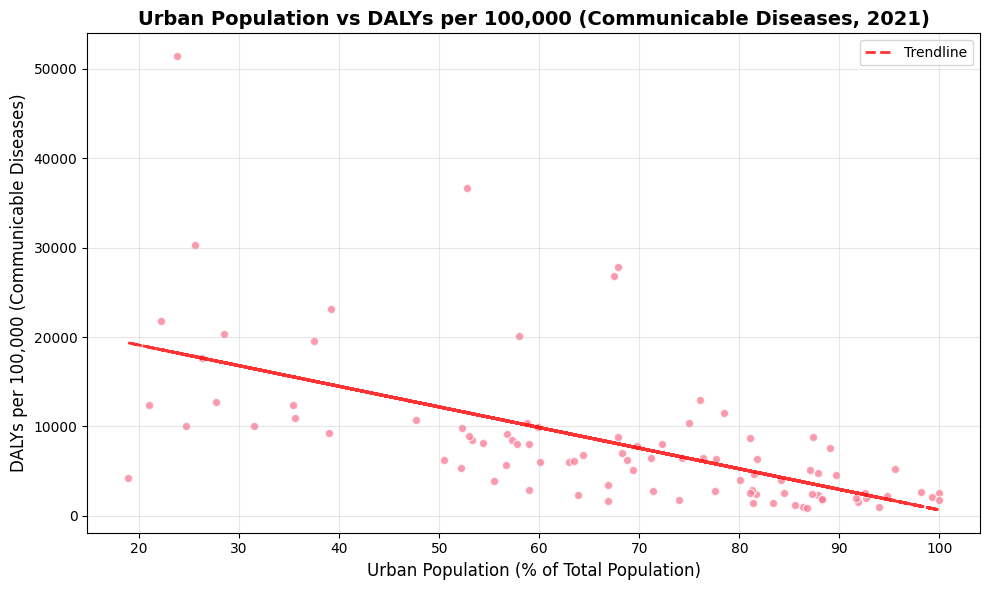

In [30]:
# Scatter plot communicable DALYs vs urban population
plt.figure(figsize=(10, 6))
plt.scatter(df7['urban_population_pct'], df7['communicable_dalys_per_100k'],
            alpha=0.7, edgecolors='white', linewidth=1)
plt.xlabel('Urban Population (% of Total Population)', fontsize=12)
plt.ylabel('DALYs per 100,000 (Communicable Diseases)', fontsize=12)

plt.title('Urban Population vs DALYs per 100,000 (Communicable Diseases, 2021)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
# Add trendline
z = np.polyfit(df7['urban_population_pct'], df7['communicable_dalys_per_100k'], 1)
p = np.poly1d(z)
plt.plot(df7['urban_population_pct'], p(df7['urban_population_pct']), "r--", alpha=0.8, linewidth=2, label='Trendline')

plt.legend()
plt.tight_layout()
plt.show()

**Observation**: As the population become more urbanized, the DALYs from communicable diseases tend to decrease, indicating that urbanization may be associated with better health outcomes in terms of communicable diseases.

In [31]:
# Test how well air_quality_pm25 and clean_water_pct predict DALYs, controlling for urbanization.
import statsmodels.api as sm
X = df7[['air_quality_pm25', 'clean_water_pct', 'urban_population_pct']]
y = df7['communicable_dalys_per_100k']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     communicable_dalys_per_100k   R-squared:                       0.653
Model:                                     OLS   Adj. R-squared:                  0.641
Method:                          Least Squares   F-statistic:                     55.26
Date:                         Fri, 11 Jul 2025   Prob (F-statistic):           3.54e-20
Time:                                 16:30:03   Log-Likelihood:                -911.59
No. Observations:                           92   AIC:                             1831.
Df Residuals:                               88   BIC:                             1841.
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [32]:
# Test if urbanization (moderator) changes the effect of pollution/water on DALYs.
df7['pollution_x_urban'] = df7['air_quality_pm25'] * df7['urban_population_pct']
df7['water_x_urban'] = df7['clean_water_pct'] * df7['urban_population_pct']
X_interaction = df7[['air_quality_pm25', 'clean_water_pct', 'urban_population_pct', 'pollution_x_urban', 'water_x_urban']]
model_interaction = sm.OLS(y, sm.add_constant(X_interaction)).fit()
print(model_interaction.summary())

                                 OLS Regression Results                                
Dep. Variable:     communicable_dalys_per_100k   R-squared:                       0.675
Model:                                     OLS   Adj. R-squared:                  0.656
Method:                          Least Squares   F-statistic:                     35.65
Date:                         Fri, 11 Jul 2025   Prob (F-statistic):           1.36e-19
Time:                                 16:30:04   Log-Likelihood:                -908.67
No. Observations:                           92   AIC:                             1829.
Df Residuals:                               86   BIC:                             1844.
Df Model:                                    5                                         
Covariance Type:                     nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

### Analysis of Results:

1. **Air Quality and Clean Water Access**:
   - Both models confirm that higher PM2.5 levels increase communicable DALYs, while better access to clean water reduces them. These findings highlight the critical role of environmental factors in communicable disease burden.

2. **Urbanization**:
   - Urbanization alone does not have a significant direct effect on communicable DALYs in either model.
   - However, the significant interaction between air pollution and urbanization in the second model suggests that urbanization mitigates the negative impact of air pollution, likely due to better infrastructure and healthcare in urban areas.

3. **Interaction Effects**:
   - The interaction between air pollution and urbanization is significant, supporting the hypothesis that urbanization reduces the impact of environmental risks.
   - The interaction between clean water access and urbanization is not significant, suggesting that urbanization does not further enhance the benefits of clean water access.

---

### Conclusion:
The analysis supports the hypothesis that urbanization moderates the relationship between air pollution and communicable DALYs, reducing its negative impact. However, urbanization does not significantly enhance the effect of clean water access.

##### **Research Question 8**: Does higher health expenditure per capita reduce the total DALYs per 100,000 population?
##### **Hypothesis**: Controlling for GDP and HDI, higher health expenditure per capita reduces total DALYs.

In [33]:
df8 = health_exp_df.merge(dalys_rate_2021[['location_name', 'val']],
                          left_on='country', right_on='location_name', how='inner')

df8 = df8[['country', 'health_expenditure', 'val']].rename(columns={'val': 'dalys_rate'})

df8 = df8.merge(gdp_df[['country', 'gdp_per_capita']], on='country', how='inner')
df8 = df8.merge(hdi_df[['country', 'hdi']], on='country', how='inner')

df8['health_expenditure'] = pd.to_numeric(df8['health_expenditure'], errors='coerce')
df8['dalys_rate'] = pd.to_numeric(df8['dalys_rate'], errors='coerce')
df8['gdp_per_capita'] = pd.to_numeric(df8['gdp_per_capita'], errors='coerce')
df8['hdi'] = pd.to_numeric(df8['hdi'], errors='coerce')
df8 = df8.dropna()

print(df8)

                 country  health_expenditure   dalys_rate  gdp_per_capita  \
0                Albania            7.399132  34816.53755     6413.282808   
1                Algeria            5.011057  28024.94386     4160.559267   
2                Andorra            8.334507  27497.83696    42425.699680   
3                 Angola            3.092771  47727.66851     1925.874661   
4    Antigua and Barbuda            4.991968  31298.07810    17348.600700   
..                   ...                 ...          ...             ...   
159           Uzbekistan            7.697742  29234.50057     2258.519641   
160              Vanuatu            4.547044  35709.49431     3211.719473   
161             Viet Nam            4.537569  28022.77625     3704.193559   
162               Zambia            6.639514  50093.12213     1127.160779   
163             Zimbabwe            2.785717  62030.78814     1724.387271   

       hdi  
0    0.796  
1    0.745  
2    0.858  
3    0.586  
4    0.788

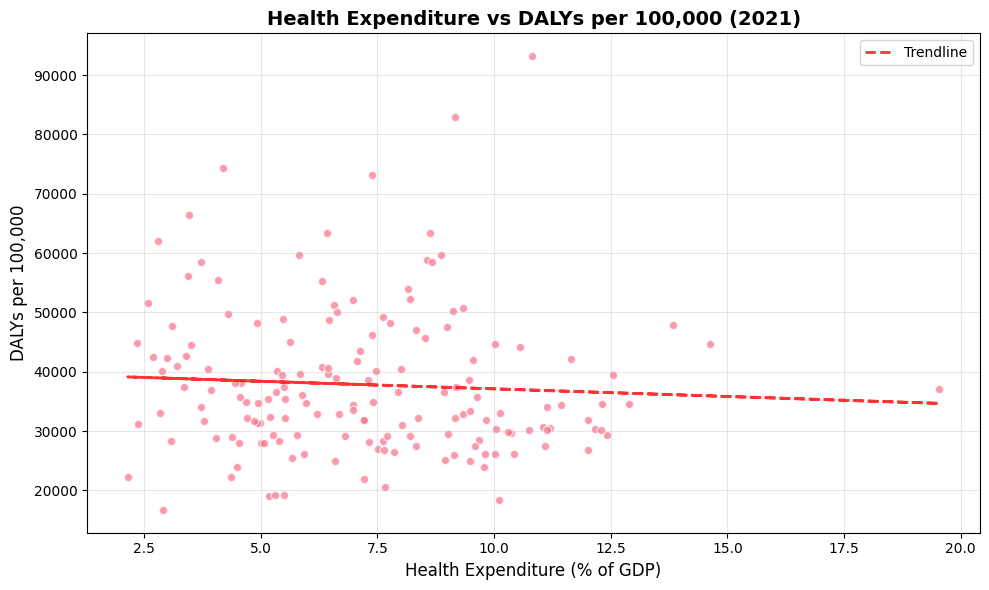

In [34]:
# Scatter plot for health expenditure vs DALYs
plt.figure(figsize=(10, 6))
plt.scatter(df8['health_expenditure'], df8['dalys_rate'], alpha=0.7, edgecolors='white', linewidth=1)
plt.xlabel('Health Expenditure (% of GDP)', fontsize=12)

plt.ylabel('DALYs per 100,000', fontsize=12)
plt.title('Health Expenditure vs DALYs per 100,000 (2021)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
# Add trendline
z = np.polyfit(df8['health_expenditure'], df8['dalys_rate'], 1)
p = np.poly1d(z)
plt.plot(df8['health_expenditure'], p(df8['health_expenditure']), "r--", alpha=0.8, linewidth=2, label='Trendline') 
plt.legend()
plt.tight_layout()
plt.show()

**Observation**: The points are widely scattered, showing significant variability in DALYs across countries with similar levels of health expenditure.

The red dashed trendline shows a slight negative slope, indicating that higher health expenditure (% of GDP) is weakly associated with lower Disability-Adjusted Life Years (DALYs) per 100,000 population. This suggests that increased health spending may contribute to improved health outcomes, but the effect is not strong.

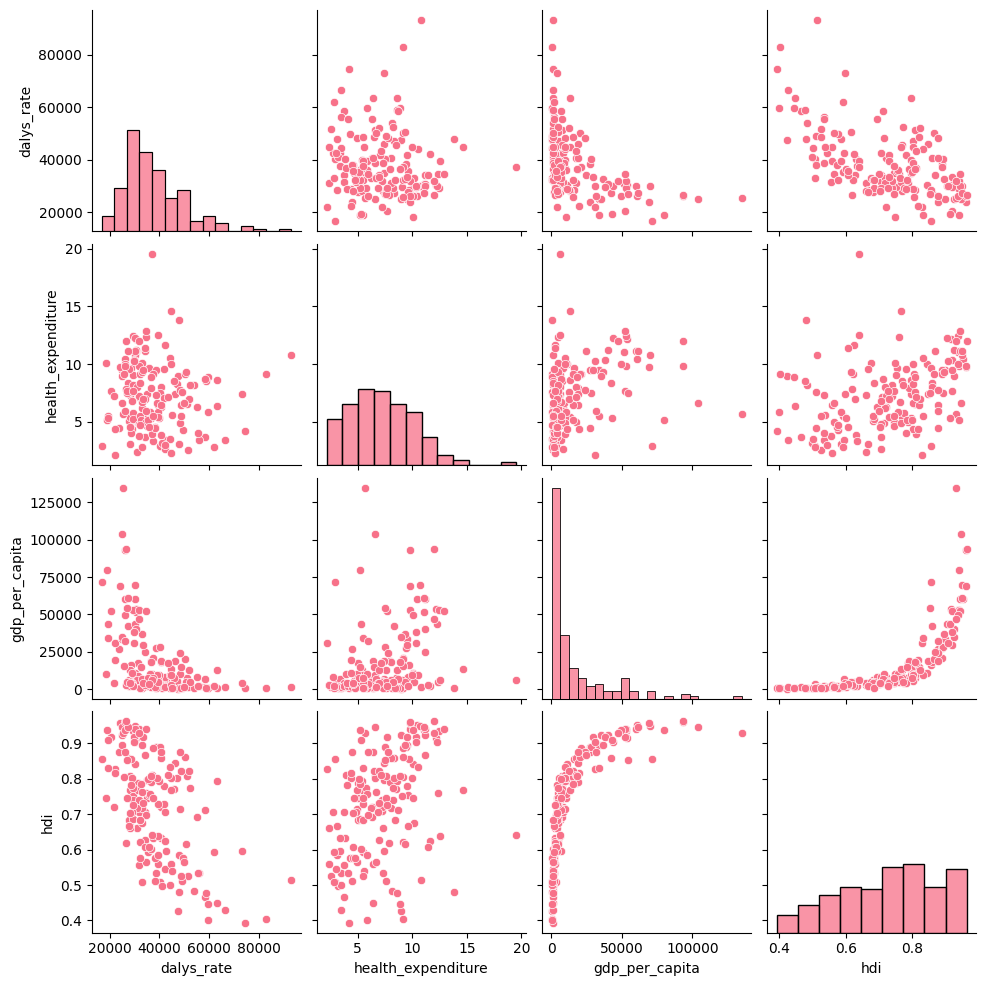

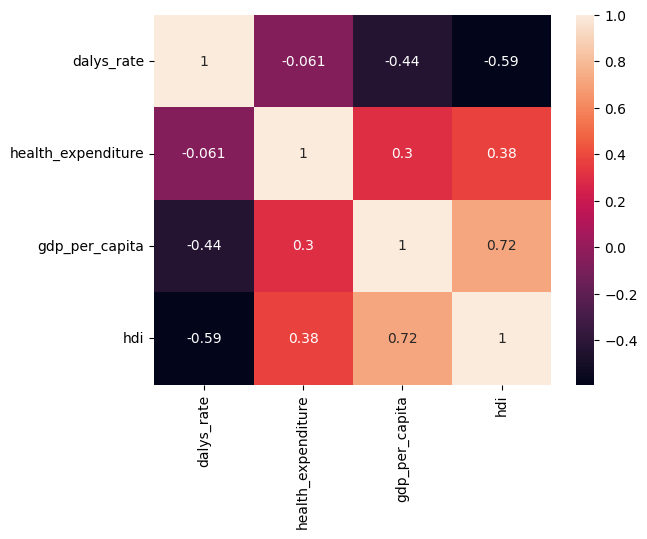

In [35]:
# Pairplot to check correlations
sns.pairplot(df8[['dalys_rate', 'health_expenditure', 'gdp_per_capita', 'hdi']])
plt.show()

# Correlation matrix
sns.heatmap(df8[['dalys_rate', 'health_expenditure', 'gdp_per_capita', 'hdi']].corr(), annot=True)
plt.show()

**Observations from the Exploratory Data Analysis (EDA)**

**Interdependence** - Health expenditure is positively correlated with GDP per capita and HDI, indicating that wealthier and more developed countries invest more in healthcare.

**Multicollinearity** - The strong correlation between `gdp_per_capita` and `hdi` (0.72) suggests potential multicollinearity, which should be addressed in regression models.

---

The EDA highlights that while health expenditure has a weak association with DALYs, economic and human development indicators (GDP per capita and HDI) play a more significant role in reducing health burdens. Further analysis should focus on controlling for multicollinearity and exploring interaction effects between these variables.

Variance Inflation Factors:
               Variable       VIF
0  health_exp_centered  1.183315
1         hdi_centered  1.182228
2         health_x_hdi  1.021480

Base Model Summary:
                            OLS Regression Results                            
Dep. Variable:              log_dalys   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     51.00
Date:                Fri, 11 Jul 2025   Prob (F-statistic):           6.98e-18
Time:                        16:30:07   Log-Likelihood:                 3.3596
No. Observations:                 164   AIC:                           -0.7193
Df Residuals:                     161   BIC:                             8.580
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          co

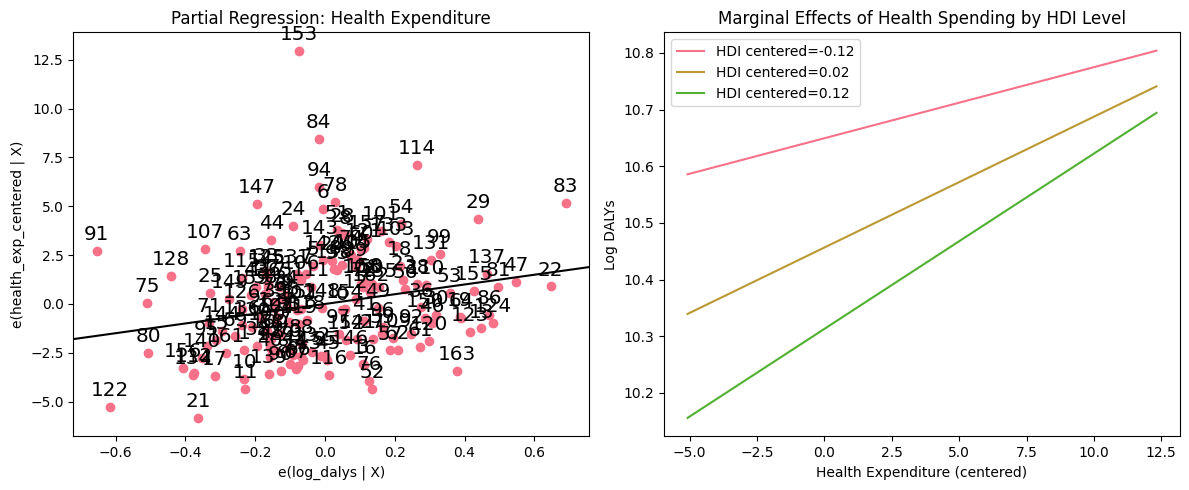


Robust Standard Errors (HC3):
                            OLS Regression Results                            
Dep. Variable:              log_dalys   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     38.05
Date:                Fri, 11 Jul 2025   Prob (F-statistic):           1.29e-18
Time:                        16:30:08   Log-Likelihood:                 4.9296
No. Observations:                 164   AIC:                            -1.859
Df Residuals:                     160   BIC:                             10.54
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
con

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create log-transformed DALYs (add small constant to avoid log(0))
df8['log_dalys'] = np.log(df8['dalys_rate'] + 1)  

# Center variables for interaction terms
df8['hdi_centered'] = df8['hdi'] - df8['hdi'].mean()
df8['health_exp_centered'] = df8['health_expenditure'] - df8['health_expenditure'].mean()

# Create interaction term (centered)
df8['health_x_hdi'] = df8['health_exp_centered'] * df8['hdi_centered']

# 2. Check Multicollinearity
X = df8[['health_exp_centered', 'hdi_centered', 'health_x_hdi']]
vif = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print("Variance Inflation Factors:\n", vif)

# 3. Run Revised Models
# Model 1: Base model with log(DALYs)
X_base = df8[['health_exp_centered', 'hdi_centered']]
X_base = sm.add_constant(X_base)
model_base = sm.OLS(df8['log_dalys'], X_base).fit()

# Model 2: With interaction term
X_inter = df8[['health_exp_centered', 'hdi_centered', 'health_x_hdi']]
X_inter = sm.add_constant(X_inter)
model_inter = sm.OLS(df8['log_dalys'], X_inter).fit()

# 4. Model Comparison
print("\nBase Model Summary:")
print(model_base.summary())

print("\nInteraction Model Summary:")
print(model_inter.summary())

# Compare AIC/BIC
print(f"\nModel Comparison:")
print(f"Base Model AIC: {model_base.aic:.1f}, BIC: {model_base.bic:.1f}")
print(f"Interaction Model AIC: {model_inter.aic:.1f}, BIC: {model_inter.bic:.1f}")

# 5. Diagnostic Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Partial regression plot for health expenditure
sm.graphics.plot_partregress('health_exp_centered', 'log_dalys', 
                           ['hdi_centered'], data=df8, ax=axes[0])
axes[0].set_title('Partial Regression: Health Expenditure')

# Marginal effects plot if interaction is significant
if model_inter.pvalues['health_x_hdi'] < 0.1:  # Only plot if marginally significant
    # Manually plot marginal effects for different HDI levels
    health_range = np.linspace(df8['health_exp_centered'].min(), df8['health_exp_centered'].max(), 100)
    hdi_levels = [
        df8['hdi_centered'].quantile(0.25),
        df8['hdi_centered'].median(),
        df8['hdi_centered'].quantile(0.75)
    ]
    for hdi in hdi_levels:
        y_pred = (model_inter.params['const'] +
                  model_inter.params['health_exp_centered'] * health_range +
                  model_inter.params['hdi_centered'] * hdi +
                  model_inter.params['health_x_hdi'] * health_range * hdi)
        axes[1].plot(health_range, y_pred, label=f'HDI centered={hdi:.2f}')
    axes[1].set_xlabel('Health Expenditure (centered)')
    axes[1].set_ylabel('Log DALYs')
    axes[1].set_title('Marginal Effects of Health Spending by HDI Level')
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, 'Interaction not significant', 
                ha='center', va='center')
    axes[1].set_title('No Significant Interaction')

plt.tight_layout()
plt.show()

# 6. Robustness Check with Huber-White SE
print("\nRobust Standard Errors (HC3):")
print(model_inter.get_robustcov_results(cov_type='HC3').summary())

**Analysis of Results**: In conclusion, the analysis provides mixed but insightful evidence regarding the relationship between health expenditure and the total burden of disease measured by DALYs. While higher health expenditure per capita is unexpectedly associated with slightly higher DALYs on average, this effect is significantly moderated by a country’s Human Development Index (HDI). Specifically, in countries with higher HDI, increased health spending is linked to lower DALYs, supporting the hypothesis that spending is more effective when development levels are higher. In contrast, in lower-HDI countries, increased expenditure may not yield the same health benefits, possibly due to inefficiencies, poor governance, or reactive rather than preventive spending. This highlights that health investment alone is not sufficient—its effectiveness depends on the broader socioeconomic and institutional context.

##### **Research Question 9**: To what extent does income inequality (Gini Index) moderate the relationship between a nation's GDP per capita and its total DALYs?
##### **Hypothesis**: The expected negative correlation between GDP per capita and total DALYs is weaker in countries with high income inequality (a high Gini Index), as the health benefits of economic growth are not distributed evenly across the population.

In [37]:
df9 = gdp_df.merge(
    gini_df[['country', 'gini_index']],
    on='country', how='inner'
)

df9 = df9.merge(
    dalys_clean[['country', 'dalys_rate']],
    on='country', how='inner'
)

df9['gdp_per_capita'] = pd.to_numeric(df9['gdp_per_capita'], errors='coerce')
df9['dalys_rate'] = pd.to_numeric(df9['dalys_rate'], errors='coerce')
df9['gini_index'] = pd.to_numeric(df9['gini_index'], errors='coerce')
df9 = df9.dropna()

print("df9 shape:", df9.shape)
print(df9.head())

df9 shape: (68, 4)
     country  gdp_per_capita  gini_index   dalys_rate
0  Argentina    10738.017920        42.4  30304.34372
1    Armenia     4685.179971        27.9  34508.08024
2    Austria    53648.719070        30.7  30415.36700
3    Belgium    51658.238290        26.6  30704.53906
4      Benin     1318.651581        34.4  51655.81526


In [38]:
# Mean-center the variables
df9['gdp_per_capita_centered'] = df9['gdp_per_capita'] - df9['gdp_per_capita'].mean()
df9['gini_index_centered'] = df9['gini_index'] - df9['gini_index'].mean()

# Create interaction term
df9['gdp_gini_interaction'] = df9['gdp_per_capita_centered'] * df9['gini_index_centered']

In [39]:
#Inference

X = df9[['gdp_per_capita_centered', 'gini_index_centered', 'gdp_gini_interaction']]
X = sm.add_constant(X)
y = df9['dalys_rate']

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             dalys_rate   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     6.079
Date:                Fri, 11 Jul 2025   Prob (F-statistic):            0.00105
Time:                        16:30:08   Log-Likelihood:                -724.10
No. Observations:                  68   AIC:                             1456.
Df Residuals:                      64   BIC:                             1465.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    3

In [40]:
# Prediction with LR

X = df9[['gdp_per_capita_centered', 'gini_index_centered', 'gdp_gini_interaction']]
y = df9['dalys_rate']

model = LinearRegression().fit(X, y)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Coefficients: [-2.49797257e-01 -3.53178719e+02 -1.14674722e-02]
Intercept: 36512.847989010275


<Figure size 1000x600 with 0 Axes>

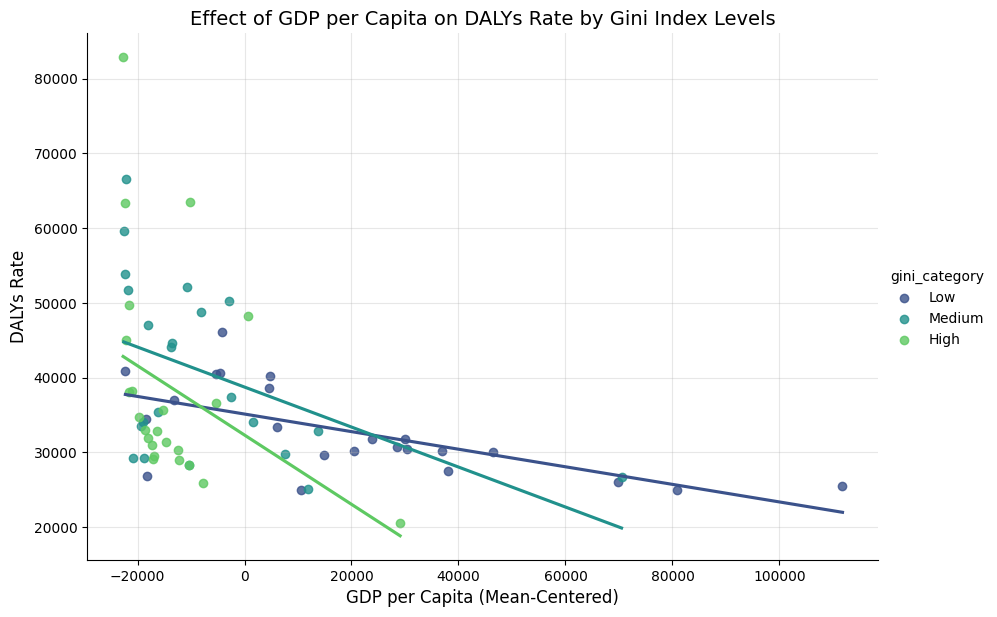

In [41]:
df9['gini_category'] = pd.qcut(df9['gini_index'], q=3, labels=['Low', 'Medium', 'High'])

# Plot GDP vs. DALYs rate, colored by Gini levels
plt.figure(figsize=(10, 6))
sns.lmplot(
    data=df9,
    x='gdp_per_capita_centered',
    y='dalys_rate',
    hue='gini_category',
    ci=None,
    palette='viridis',
    height=6,
    aspect=1.5
)

plt.title("Effect of GDP per Capita on DALYs Rate by Gini Index Levels", fontsize=14)
plt.xlabel("GDP per Capita (Mean-Centered)", fontsize=12)
plt.ylabel("DALYs Rate", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

Based on the regression analysis and visual evidence, we conclude that GDP per capita has a significant negative relationship with DALYs rates; countries with higher income levels tend to experience a lower burden of disease. However, contrary to the hypothesis, the interaction between GDP per capita and the Gini Index is not statistically significant (p = 0.452), indicating that income inequality does not significantly moderate this relationship. The visual plot shows slightly steeper negative slopes for low-inequality countries, but these differences are not robustly supported by the statistical model. Therefore, while economic prosperity generally improves health outcomes, this effect does not appear to be significantly weakened in countries with high income inequality based on the current model and dataset.

##### **Research Question 10**: Does government effectiveness strengthen the negative relationship between healthcare expenditure (% of GDP) and DALYs per 100k?
##### **Hypothesis**: The negative association between healthcare expenditure and DALYs will be stronger in countries with higher government effectiveness, as efficient institutions are better at translating spending into actual health improvements.

In [42]:
gov_effectiveness_df = worldbank_df[worldbank_df.iloc[:, 0] == "Government Effectiveness: Estimate"].copy()
gov_effectiveness_df.columns = ['indicator', 'country', 'country_code', 'gov_effectiveness']
gov_effectiveness_df = gov_effectiveness_df[['country', 'gov_effectiveness']]
gov_effectiveness_df = gov_effectiveness_df[gov_effectiveness_df['gov_effectiveness'] != '..']
gov_effectiveness_df['gov_effectiveness'] = pd.to_numeric(gov_effectiveness_df['gov_effectiveness'], errors='coerce')

print("Government Effectiveness Data:")
print(gov_effectiveness_df.shape)
print(gov_effectiveness_df.head())

Government Effectiveness Data:
(205, 2)
             country  gov_effectiveness
3190     Afghanistan          -1.670588
3193         Albania          -0.035985
3194         Algeria          -0.652746
3195  American Samoa           0.638740
3196         Andorra           1.748928


In [43]:
df10 = health_exp_df.merge(
    dalys_clean[['country', 'dalys_rate']],
    on='country', how='inner')

df10 = df10.merge(
    gov_effectiveness_df,
    on='country', how='inner'
)

print("df10 shape:", df10.shape)
print(df10.head())

df10 shape: (170, 4)
               country  health_expenditure   dalys_rate  gov_effectiveness
0              Albania            7.399132  34816.53755          -0.035985
1              Algeria            5.011057  28024.94386          -0.652746
2              Andorra            8.334507  27497.83696           1.748928
3               Angola            3.092771  47727.66851          -1.126360
4  Antigua and Barbuda            4.991968  31298.07810          -0.193901


In [44]:
# Center health expenditure
df10['health_exp_centered'] = df10['health_expenditure'] - df10['health_expenditure'].mean()

# Interactive term: health expenditure * government effectiveness
df10['health_gov_interaction'] = df10['health_exp_centered'] * df10['gov_effectiveness']

In [45]:
# Moderated Multiple Linear Regression

X = df10[['health_exp_centered', 'gov_effectiveness', 'health_gov_interaction']]
X = sm.add_constant(X)
y = df10['dalys_rate']

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             dalys_rate   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     23.47
Date:                Fri, 11 Jul 2025   Prob (F-statistic):           1.03e-12
Time:                        16:30:09   Log-Likelihood:                -1819.7
No. Observations:                 170   AIC:                             3647.
Df Residuals:                     166   BIC:                             3660.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   3.80

In [46]:
# Check for multicollinearity
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(pd.DataFrame({'Variable': X.columns, 'VIF': vif}))

                 Variable       VIF
0                   const  1.115657
1     health_exp_centered  1.128200
2       gov_effectiveness  1.128367
3  health_gov_interaction  1.000198


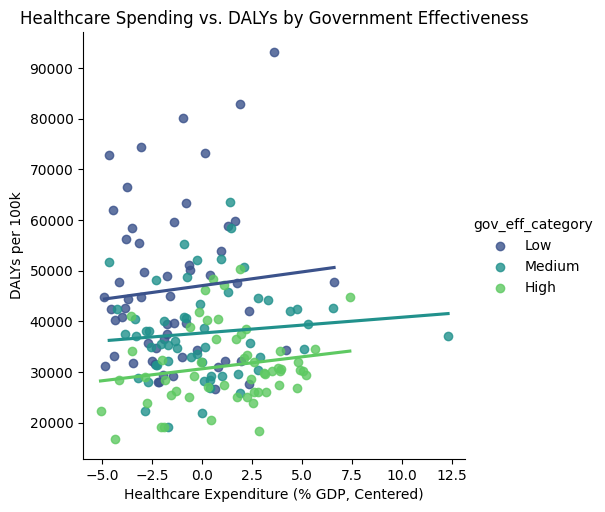

In [47]:
df10['gov_eff_category'] = pd.qcut(df10['gov_effectiveness'], q=3, labels=['Low', 'Medium', 'High'])

# Plot
sns.lmplot(
    data=df10,
    x='health_exp_centered',
    y='dalys_rate',
    hue='gov_eff_category',
    ci=None,
    palette='viridis'
)
plt.title("Healthcare Spending vs. DALYs by Government Effectiveness")
plt.xlabel("Healthcare Expenditure (% GDP, Centered)")
plt.ylabel("DALYs per 100k")
plt.show()

Based on the regression results and model diagnostics, there is no significant evidence to support the hypothesis that government effectiveness strengthens the negative relationship between healthcare expenditure and DALYs per 100,000 population. The graph also show near parallel line between each category.

While government effectiveness on its own is a strong and statistically significant predictor of lower DALYs (coef = -7469.68, p < 0.001), the interaction term between health expenditure and government effectiveness is not statistically significant (p = 0.547). This means that although more effective governments are generally associated with better health outcomes, they do not significantly amplify the impact of healthcare spending on reducing the disease burden. Additionally, healthcare expenditure itself does not show a significant direct relationship with DALYs in this model (p = 0.115), which further weakens the case for an interaction effect.

##### **Research Question 11**: What clusters of countries emerge based on DALYs, income, education, and health expenditure profiles?

In [48]:
education_df = worldbank_df[worldbank_df.iloc[:, 0] == "Government expenditure on education, total (% of GDP)"].copy()
education_df.columns = ['indicator', 'country', 'country_code', 'education_expenditure']
education_df = education_df[['country', 'education_expenditure']].dropna()
education_df['education_expenditure'] = pd.to_numeric(education_df['education_expenditure'].replace('..', None), errors='coerce')
education_df = education_df.dropna()

print("Education Expenditure Data:")
print(education_df.shape)
print(education_df.head())

Education Expenditure Data:
(208, 2)
                          country  education_expenditure
3457  Africa Eastern and Southern               4.771326
3458   Africa Western and Central               3.203484
3459                      Albania               3.022560
3460                      Algeria               5.514033
3462                      Andorra               2.583972


In [49]:
df11 = hdi_df.merge(
    dalys_clean[['country', 'dalys_rate']],
    on='country', how='inner'
)

df11 = df11.merge(
    education_df,
    on='country', how='inner'
)

df11 = df11.merge(
    health_exp_df[['country', 'health_expenditure']],
    on='country', how='inner',
)

print("df11 shape:", df11.shape)
print(df11.head())

df11 shape: (142, 5)
       country    hdi   dalys_rate  education_expenditure  health_expenditure
0  Switzerland  0.962  26744.63755                5.03709           12.004656
1       Norway  0.961  26072.25829                6.96022            9.814264
2      Iceland  0.959  23942.96330                8.21781            9.786970
3    Australia  0.951  26047.19552                5.33321           10.425253
4      Denmark  0.948  30118.24605                6.99993           10.747286


In [50]:
features = ['hdi', 'dalys_rate', 'education_expenditure', 'health_expenditure']
X = df11[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=df11.index) # Keep index for merging later

print("Scaled Data Head:")
print(X_scaled_df.head())

Scaled Data Head:
        hdi  dalys_rate  education_expenditure  health_expenditure
0  1.501278   -0.893384               0.245878            1.662279
1  1.494651   -0.947196               1.245968            0.870709
2  1.481397   -1.117608               1.899955            0.860846
3  1.428380   -0.949202               0.399870            1.091510
4  1.408499   -0.623387               1.266619            1.207887


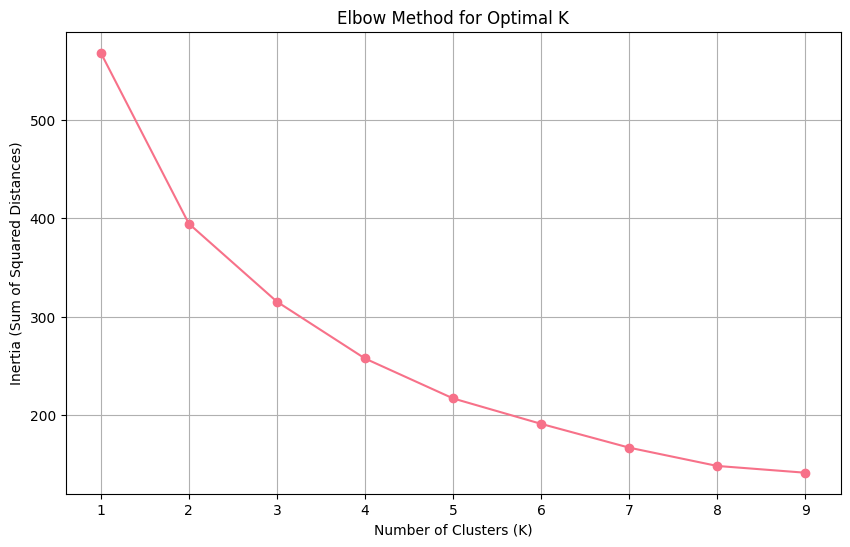

In [51]:
# Elbow Method
inertia = []
for k in range(1, 10): # Test k from 1 to 9
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)
plt.show()

K=2, Silhouette Score: 0.338
K=3, Silhouette Score: 0.268
K=4, Silhouette Score: 0.272
K=5, Silhouette Score: 0.278
K=6, Silhouette Score: 0.275
K=7, Silhouette Score: 0.291
K=8, Silhouette Score: 0.315
K=9, Silhouette Score: 0.254


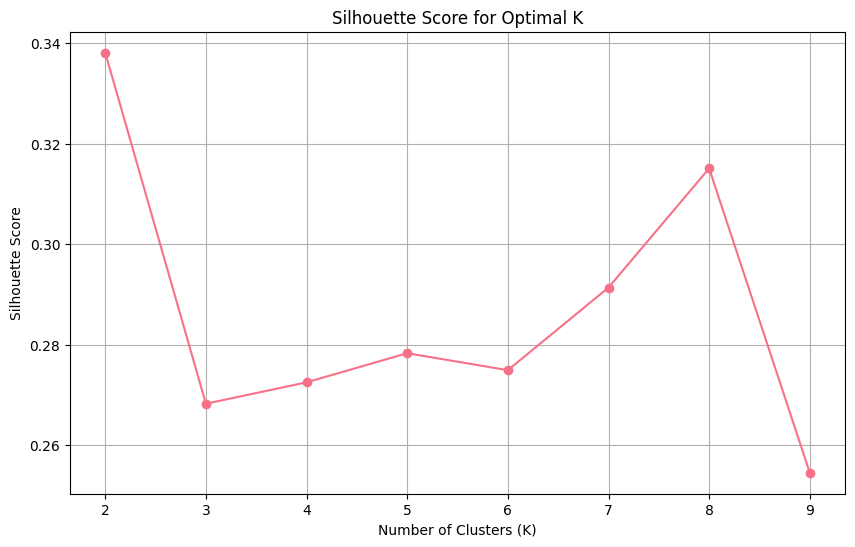

In [52]:
from sklearn.metrics import silhouette_score

# Silhouette Score Method
silhouette_scores = []
for k in range(2, 10): # Test k from 2 to 9
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score: {score:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [53]:
optimal_k = 2

# Perform Clustering
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df11['cluster'] = kmeans_final.fit_predict(X_scaled)

cluster_profiles = df11.groupby('cluster')[features].mean()
print("\nCluster Profiles (Mean of Original Values):")
print(cluster_profiles)



Cluster Profiles (Mean of Original Values):
              hdi    dalys_rate  education_expenditure  health_expenditure
cluster                                                                   
0        0.805577  33447.821730               4.935510            8.116267
1        0.543579  50112.756245               3.548269            5.457941


In [54]:
df11_plot = df11.copy()
df11_plot[features] = X_scaled

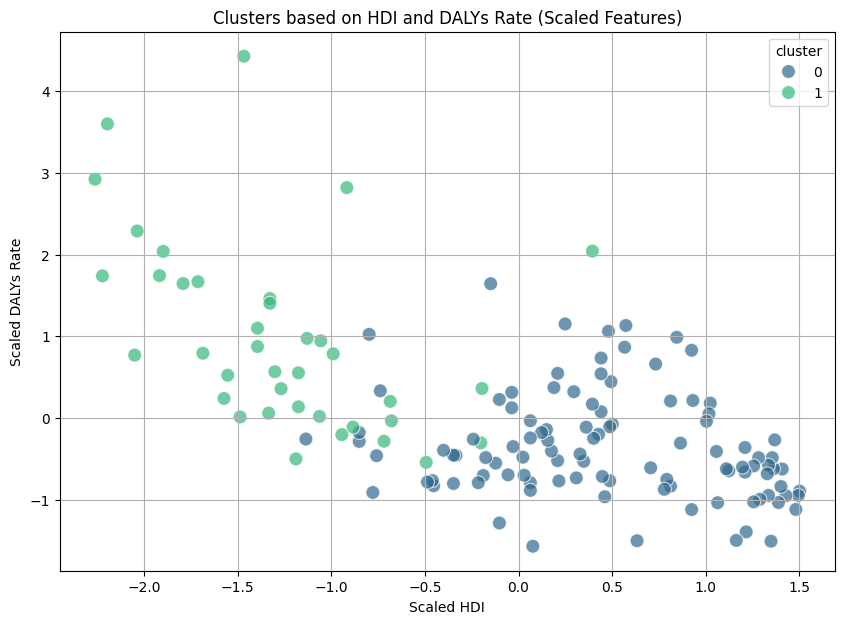

In [55]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='hdi', y='dalys_rate', hue='cluster', data=df11_plot, palette='viridis', s=100, alpha=0.7)
plt.title('Clusters based on HDI and DALYs Rate (Scaled Features)')
plt.xlabel('Scaled HDI')
plt.ylabel('Scaled DALYs Rate')
plt.grid(True)
plt.show()

<Figure size 1500x1500 with 0 Axes>

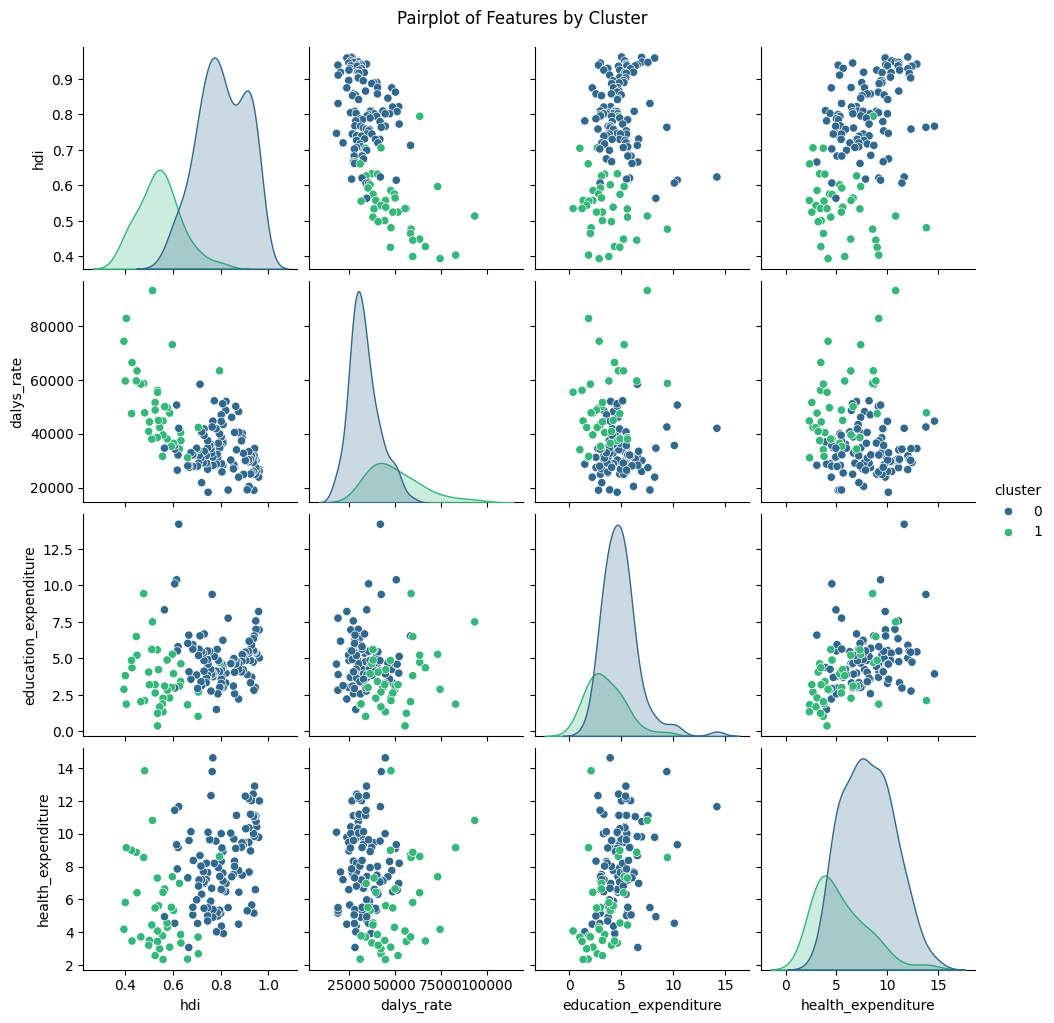

In [56]:
# see how each feature varies across clusters
plt.figure(figsize=(15, 15))
sns.pairplot(df11, vars=features, hue='cluster', palette='viridis')
plt.suptitle('Pairplot of Features by Cluster', y=1.02)
plt.show()

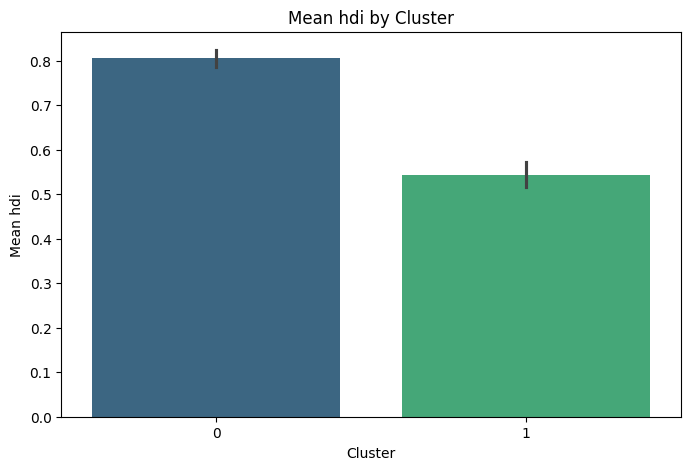

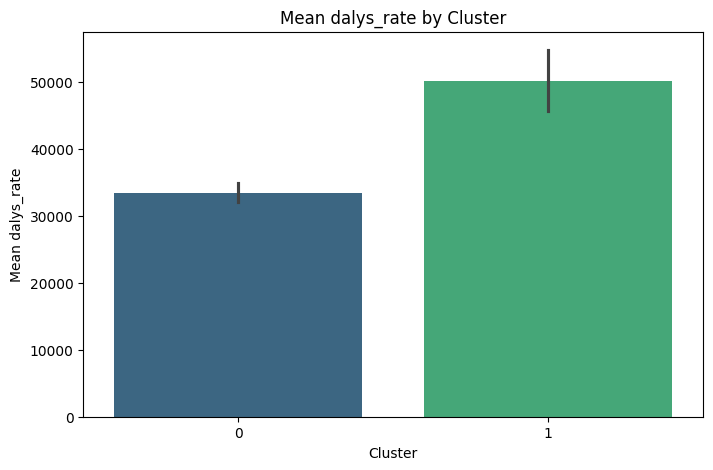

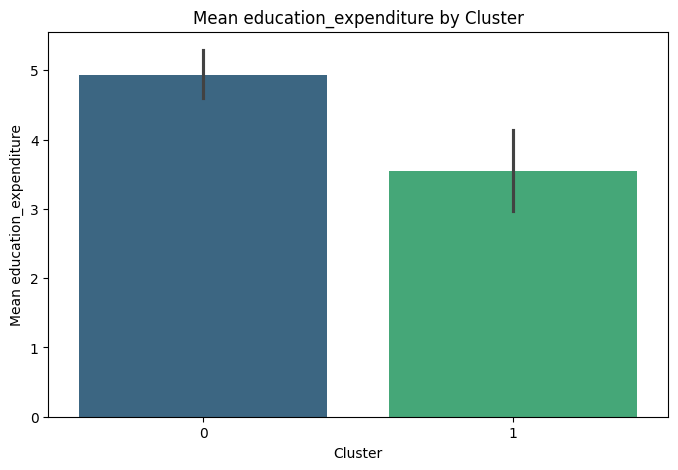

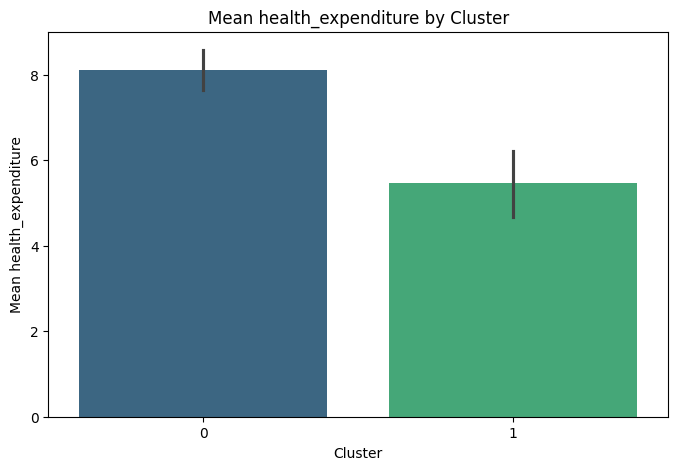

In [57]:
# Bar plots for each feature per cluster to clearly show the profiles
for feature in features:
    plt.figure(figsize=(8, 5))
    sns.barplot(x='cluster', y=feature, data=df11, palette='viridis', estimator='mean')
    plt.title(f'Mean {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'Mean {feature}')
    plt.show()

**Conclusion**: Two distinct clusters emerge. The "Elbow Method" plot suggested that K=2 as an optimal number of clusters, with a significant drop in inertia observed from K=1 to K=2. The "Clusters based on HDI and DALYs Rate" scatter plot visually confirmed a clear separation, showing one cluster predominantly in the higher HDI and lower DALYs range, and another in the lower HDI and higher DALYs range. Further validation through "Mean hdi by Cluster" and "Mean dalys_rate by Cluster" bar charts revealed that Cluster 0 countries exhibit significantly higher mean HDI (around 0.8) and lower mean DALYs Rate (around 33,000), while Cluster 1 countries show the opposite trend with lower mean HDI (around 0.55) and higher mean DALYs Rate (around 50,000).

The two identified country profiles can be characterized as follows: Cluster 0 represents "High Human Development & Lower Disease Burden" nations. These countries are generally more developed, characterized by higher human development and a reduced burden of disease. This is further supported by their higher mean government expenditures on both education (around 5.0% of GDP) and health (around 8.0% of GDP). In contrast, Cluster 1 embodies "Lower Human Development & Higher Disease Burden" nations. These countries tend to be less developed, facing significant public health challenges and lower levels of human development. Their profiles are marked by correspondingly lower mean expenditures in education (around 3.5% of GDP) and health (around 5.5% of GDP). This clear demarcation highlights the strong correlation between investment in social sectors, overall human development, and public health outcomes within the analyzed dataset.

##### **Research Question 12**: Considering additional socio-economic and environmental factors such as urbanization, access to clean water, air pollution, and income inequality (Gini coefficient), can we identify distinct country development profiles, and subsequently, determine optimal allocations of health and education expenditures that are most effective in minimizing DALYs for each of these profiles?

In [66]:
# Create df12
df12 = df11[['country', 'hdi', 'dalys_rate', 'education_expenditure', 'health_expenditure', 'cluster']].copy()
df12 = df12.merge(urban_df[['country', 'urban_population_pct']], on='country', how='inner')
df12 = df12.merge(clean_water_df[['country', 'percentage']], on='country', how='inner')
df12 = df12.merge(gov_effectiveness_df[['country', 'gov_effectiveness']], on='country', how='inner')
df12 = df12.merge(gini_df[['country', 'gini_index']], on='country', how='inner')

# Convert columns to numeric
for col in df12.columns:
    if col != 'country':
        df12[col] = pd.to_numeric(df12[col], errors='coerce')

print("df12 shape:", df12.shape)
print(df12.head())

df12 shape: (62, 10)
       country    hdi   dalys_rate  education_expenditure  health_expenditure  \
0  Switzerland  0.962  26744.63755                5.03709           12.004656   
1       Norway  0.961  26072.25829                6.96022            9.814264   
2      Denmark  0.948  30118.24605                6.99993           10.747286   
3       Sweden  0.947  27452.40336                7.57220           11.101806   
4      Ireland  0.945  25005.52571                3.00598            6.596145   

   cluster  urban_population_pct  percentage  gov_effectiveness  gini_index  
0        0                73.996  100.000000           1.990798        33.8  
1        0                83.323  100.000000           1.795399        29.1  
2        0                88.240  100.000000           1.959734        28.3  
3        0                88.238   99.738446           1.610255        29.8  
4        0                63.912   95.995831           1.463425        29.4  


Global Regression Model Summary
                            OLS Regression Results                            
Dep. Variable:             dalys_rate   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.224
Date:                Fri, 11 Jul 2025   Prob (F-statistic):              0.304
Time:                        16:39:27   Log-Likelihood:                -1539.1
No. Observations:                 142   AIC:                             3086.
Df Residuals:                     138   BIC:                             3098.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

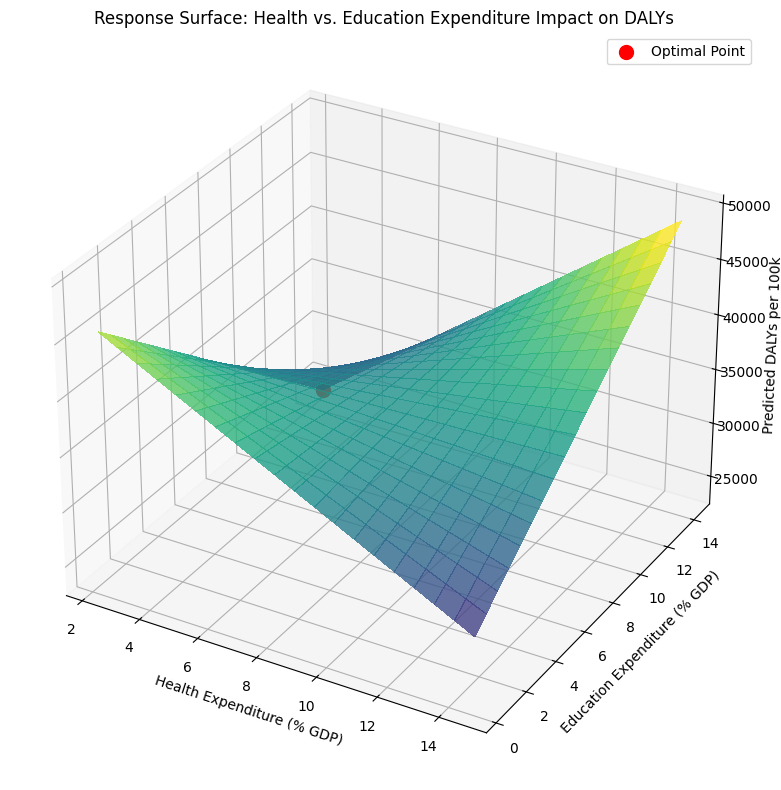

In [69]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df12 = df11.copy()

# 1. Standardize variables for fair comparison in optimization
scaler = StandardScaler()
expenditure_cols = ['health_expenditure', 'education_expenditure']
df12[expenditure_cols] = scaler.fit_transform(df12[expenditure_cols])

# 2. Prepare data for global optimization
X = df12[expenditure_cols]
X['interaction'] = X['health_expenditure'] * X['education_expenditure']
X = sm.add_constant(X)
y = df12['dalys_rate']

# 3. Fit global regression model
global_model = sm.OLS(y, X).fit()
print("="*80)
print("Global Regression Model Summary")
print("="*80)
print(global_model.summary())

# 4. Define optimization function
def dalys_function(x):
    health, education = x
    features = [1, health, education, health * education]
    return global_model.predict(features)[0]

# 5. Find global optimal allocation
bounds = [
    (df12['health_expenditure'].min(), df12['health_expenditure'].max()),
    (df12['education_expenditure'].min(), df12['education_expenditure'].max())
]

result = minimize(
    dalys_function,
    x0=df12[expenditure_cols].mean().values,
    bounds=bounds,
    method='L-BFGS-B'
)

# 6. Process and display results
if result.success:
    # Inverse transform to original scale
    optimal_scaled = np.array([result.x])
    optimal_original = scaler.inverse_transform(optimal_scaled)
    
    print("\n" + "="*80)
    print("Global Optimal Allocation Results")
    print("="*80)
    print(f"- Optimal health expenditure: {optimal_original[0, 0]:.2f}% of GDP")
    print(f"- Optimal education expenditure: {optimal_original[0, 1]:.2f}% of GDP")
    print(f"- Predicted minimum DALYs: {result.fun:.0f} per 100k")
    
    # 7. Create response surface visualization
    health_range = np.linspace(df12['health_expenditure'].min(), 
                              df12['health_expenditure'].max(), 20)
    edu_range = np.linspace(df12['education_expenditure'].min(), 
                           df12['education_expenditure'].max(), 20)
    
    H, E = np.meshgrid(health_range, edu_range)
    D = np.array([dalys_function([hi, ei]) for hi, ei in zip(H.ravel(), E.ravel())])
    D = D.reshape(H.shape)
    
    # Transform back to original scale for plotting
    health_original = scaler.inverse_transform(np.column_stack((H.ravel(), E.ravel())))[:, 0].reshape(H.shape)
    edu_original = scaler.inverse_transform(np.column_stack((H.ravel(), E.ravel())))[:, 1].reshape(E.shape)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(health_original, edu_original, D, cmap='viridis',
                          alpha=0.8, linewidth=0, antialiased=False)
    
    # Plot optimal point
    ax.scatter(optimal_original[0, 0], optimal_original[0, 1], result.fun, 
               color='red', s=100, label='Optimal Point')
    
    ax.set_xlabel('Health Expenditure (% GDP)')
    ax.set_ylabel('Education Expenditure (% GDP)')
    ax.set_zlabel('Predicted DALYs per 100k')
    ax.set_title('Response Surface: Health vs. Education Expenditure Impact on DALYs')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
else:
    print("Optimization failed to converge")